In [1]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, halfnorm
%matplotlib inline

In [2]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [3]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [4]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [5]:
m_true = 0.0
b_true = .5

delty1_true = 0.0
delty2_true = 0.3
sigsq1_true = .01
sigsq2_true = .04
a1_true = .5
a2_true = .5
L_true = 1.0

In [6]:
# adapted code from http://code.activestate.com/recipes/189971-basic-linear-algebra-matrix/
def minor(matrix, i, j):
    #input should be numpy matrix
    matrix = np.asarray(matrix)
    m = np.zeros((matrix.shape[0]-1, matrix.shape[1]-1))
    m = np.matrix(m)
    # loop through the matrix, skipping over the row and column specified by i and j
    minor_row = minor_col = 0
    for row in range(matrix.shape[0]):
        if not row == i: # skip row i
            for col in range(matrix.shape[1]):
                if not col == j: # skip column j
                    m[(minor_row, minor_col)] = matrix[(row, col)]
                    minor_col += 1
            minor_col = 0
            minor_row += 1
    return m

In [72]:
def lnlike(theta, x, y):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
#     a2 = 1.0 - a1
    BN_lim = 200
    #number in variable name is the gaussian j
    
#     delty1_true = 0.0
#     delty2_true = 0.3
#     sigsq1_true = .01
#     sigsq2_true = .04

    y_mod1 = m*x + b - delty1
    y_mod2 = m*x + b - delty2
    chisq1 = (1/sigsq1) * np.matmul(y-y_mod1, (y-y_mod1).T)
#     print(chisq1)
#     print(delty1/sigsq1)
    chisq2 = (1/sigsq2) * np.matmul(y-y_mod2, (y-y_mod2).T)
    if chisq1 > BN_lim:
        chisq1 = BN_lim
    if chisq2 > BN_lim:
        chisq2 = BN_lim
    H = [np.exp(-chisq1/2), np.exp(-chisq2/2)]
#     print(H)
    beta1 = -2.0*np.log(a1/np.sqrt(2*np.pi*sigsq1))
    beta2 = -2.0*np.log(a2/np.sqrt(2*np.pi*sigsq2))
    M = []
    for i in range(len(days)):
        if i == 0:
            temp_y = y[i+1:]
            temp_x = x[i+1:]
        else:
            temp_y = np.concatenate((y[:i],y[i+1:]))
            temp_x = np.concatenate((x[:i],x[i+1:]))
        temp_y_mod1 = m*temp_x + b - delty1
        temp_y_mod2 = m*temp_x + b - delty2
        minor_chisq1 = sigsq1 * np.matmul(temp_y-temp_y_mod1, (temp_y-temp_y_mod1).T)
        minor_chisq2 = sigsq2 * np.matmul(temp_y-temp_y_mod2, (temp_y-temp_y_mod2).T)
        M.append([np.exp(-.5*(beta1 - minor_chisq1)), np.exp(-.5*(beta2 - minor_chisq2))])
    
    MxH = np.matmul(np.matrix(M), np.matrix(H).T)
    
    #calc optimal lambda
    full_a = np.array([[a1, a2],]*len(x))
    full_H = np.array([H,]*len(x))
    N = np.multiply(np.divide(M,full_a),full_H)
    NxH = np.matmul(np.matrix(N), np.matrix(H).T)
    lambda_star = -0.5*np.sum(np.divide(NxH,MxH))
    print(lambda_star)
#     if np.any(MxH)<= 0:
#         print(MxH)
#         exit()
    return np.log(MxH).sum() + L*(a1+a2-1)

In [78]:
lnlike((0.001, .6, 0.0, 0.3, .01, .04, .5, .5, 1.0), days, planets_etamb)

-2.04976186279e-41


-36709.867654360147

In [34]:
print(np.exp(-200))
print(np.finfo(np.float64).eps)

1.38389652674e-87
2.22044604925e-16


In [22]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, delty1_true, delty2_true, sigsq1_true, sigsq2_true, a1_true, a2_true, L_true], args=(days, planets_etamb))
m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml, a2_ml, L_ml = result["x"]

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [23]:
print(m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml)

0.0 0.5 0.0 0.3 0.01 0.04 0.5


In [79]:
def lnprior(theta):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
    if 0.0 < b < 1.0 and 0.0 < a1 < 1.0 and 0.0 < a2 < 1.0 and sigsq1 > 0.0 and sigsq2 > 0.0 and L > 0.0:
        pri_m = norm.logpdf(m, 0.0, 1.0)
        pri_delty1 = norm.logpdf(delty1, 0.0, 0.5)
        pri_delty2 = norm.logpdf(delty2, 0.3, 0.5)
        pri_sigsq1 = norm.logpdf(sigsq1, .01, .01)
        pri_sigsq2 = norm.logpdf(sigsq2, .04, .01)
        pri_a1 = norm.logpdf(a1, 0.5, .5/3.0)
        pri_a2 = norm.logpdf(a2, 0.5, .5/3.0)
        pri_L = norm.logpdf(L, -2.04976186279e-41, 10**-5)
        return pri_m + pri_delty1 + pri_delty2 + pri_sigsq1 + pri_sigsq2 + pri_a1 + pri_a2 + pri_L
    return -np.inf

In [80]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [81]:
ndim, nwalkers = 9, 200
# pos = [result["x"] + np.random.randn(ndim)*1e-4*[.2, .1, .5, .3, .3] for i in range(nwalkers)] #nwalkers x ndim entries
pos = [np.random.randn(ndim)*1e-4*[0.001, .6, 0.0, 0.3, .01, .04, .5, .5, 1.0] for i in range(nwalkers)]

In [82]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb), threads=4, a=2.0)

-5.59495674926e-37
-9.62944867199e-37
-1.4490772667e-37
-2.49826387345e-37
-7.96840739266e-38
-3.197391756e-37
-2.08079466686e-37
-1.42476081615e-37
-1.4126572374e-37
-1.170956285e-36
-7.20105352495e-37
-3.05595696398e-37
-1.01112532229e-37
-1.95287918869e-37
-2.0715400185e-37
-8.00063441268e-37
-3.192144884e-37
-3.02908656693e-37
-9.698020731e-38
-9.41022905196e-38
-1.44428592139e-37
-6.5758164689e-38
-2.64191004712e-37
-2.67790041984e-37
-5.98523695983e-37
-2.67105724763e-37
-5.56532738341e-37
-1.03413169032e-36
-2.69572996175e-37
-8.03733037928e-37
-8.23527088008e-38
-1.45267975023e-37
-1.9607813159e-37
-3.05023971645e-37
-1.34358774256e-36
-8.90223206591e-38
-8.12919926594e-38
-1.3741382627e-37
-3.04434119909e-37
-1.37622865507e-36
-6.02792948855e-37
-7.4874205364e-38
-9.30931444247e-38
-2.58368118228e-37
-1.55323805462e-37
-1.27687763035e-37
-1.66576719283e-37
-8.78670922008e-38
-2.63880893202e-37
-1.02053345961e-37
-6.6566294485e-38
-4.87448310685e-38
-1.99045369583e-37
-1.260272

-1.14604188088e-37
-1.58529268099e-37
-2.03567938584e-37
-5.57952408926e-37
-8.77610982083e-38
-4.87827465819e-38
-1.09587698342e-38
-1.55674156392e-37
-1.55526535541e-37
-7.61490414979e-38
-1.46623766535e-37
-5.67653884898e-38
-6.9543312882e-38
-5.48822153436e-37
-2.73718262138e-38
-1.49401344693e-37
-1.4698792676e-37
-6.37014001501e-38
-5.43034703259e-38
-7.70154520017e-38
-2.55919031821e-37
-1.21885928096e-37
-7.5347196831e-38
-1.22077497482e-37
-2.71391942172e-38
-1.0898804867e-37
-9.32953930399e-38
-1.03221728241e-37
-3.05928704051e-38
-9.7453003883e-38
-1.3879391095e-37
-2.90329534298e-38
-9.48742973961e-38
-1.93674182096e-38
-3.3446979998e-37
-8.06054855667e-38
-1.11378200768e-37
-1.91462347575e-37
-7.92210967611e-38
-8.7362121879e-38
-7.25310105656e-38
-1.91701584301e-37
-1.6711182461e-37
-3.93500504641e-38
-2.55350481238e-38
-8.20628742845e-38
-8.98841743181e-38
-1.09783590332e-37
-4.72520187296e-38
-6.00977969812e-38
-1.41332153378e-38
-1.83702192333e-37
-1.06165971328e-37
-1

-5.18014793455e-38
-6.16758523705e-38
-1.72926114098e-37
-1.80835987758e-37
-8.06868030756e-38
-1.8739666376e-38
-4.80351244079e-39
-2.28065866759e-38
-1.95645092576e-38
-2.22240695285e-38
-4.32316246068e-39
-1.07574291156e-38
-1.06019146045e-37
-2.02691955273e-38
-1.82821095358e-38
-4.43658884035e-38
-1.39811343564e-38
-5.07239285421e-39
-1.46227385279e-37
-1.13222820635e-38
-2.16597002292e-38
-1.15877859125e-37
-4.31130712663e-38
-5.6499201056e-38
-8.39901391194e-38
-1.36124202526e-37
-1.26356538389e-37
-2.80378566026e-38
-1.84804533869e-38
-8.86320441748e-38
-5.79167062884e-39
-2.65493508904e-38
-8.15485987264e-39
-7.26378569652e-38
-3.78299954128e-38
-3.19967815733e-39
-1.65560477695e-38
-1.61091908317e-38
-6.99957210396e-38
-9.65282936447e-38
-2.61621706892e-37
-4.80528937287e-38
-5.00848266125e-38
-2.30704933978e-38
-5.62357562204e-39
-2.21367770871e-37
-2.37076364948e-38
-2.54026277929e-38
-7.69102357493e-39
-1.39774553866e-38
-2.48995670093e-38
-7.20226220896e-38
-2.59542006368

-1.55617271354e-39
-1.04698337317e-37
-3.20917416446e-38
-8.39026480672e-40
-7.61269174513e-39
-2.14711887298e-38
-2.10294698504e-37
-8.44244616563e-38
-4.46522162711e-38
-9.70829761208e-38
-9.04221054673e-39
-9.22918495135e-39
-7.05992336229e-38
-1.59361250686e-38
-7.20177718177e-39
-1.37666387322e-39
-3.18105999108e-38
-7.0790769769e-38
-2.12024140745e-38
-4.87894148101e-38
-1.19837697102e-38
-7.69489698649e-38
-2.33484857936e-38
-4.93914169088e-38
-6.8119542606e-38
-1.30230683102e-38
-3.38740589021e-38
-3.24166566939e-38
-1.57721697806e-38
-3.52481362582e-38
-2.28484211098e-38
-6.86844473712e-38
-3.66328543699e-38
-5.39460095594e-38
-1.02961310448e-37
-2.35009551304e-39
-4.69945172618e-38
-1.01152609361e-38
-2.27905744474e-38
-1.80939151321e-38
-2.30072066392e-38
-3.65566312103e-39
-1.07126443761e-37
-1.21472187765e-39
-7.84726483349e-38
-8.84246899163e-38
-5.28119414805e-39
-3.74494788735e-38
-1.97313760454e-38
-6.78587759053e-39
-5.16759329206e-39
-1.25025118615e-38
-5.06123400776

-8.30707945098e-40
-7.26181636713e-39
-3.1908252913e-38
-4.44791417041e-38
-7.77239540057e-38
-1.4174842103e-38
-1.84862670324e-37
-5.21140976107e-39
-1.3863741357e-37
-1.31319685351e-38
-3.76809054936e-38
-5.45156863915e-38
-2.69477067234e-39
-1.86926421612e-38
-1.20007900141e-38
-1.02021279011e-38
-1.73345417745e-38
-9.38541942741e-39
-2.36274551415e-38
-7.84434272563e-38
-1.48669111922e-39
-4.01852582295e-39
-3.15777973188e-38
-2.52331203145e-39
-3.56189119548e-38
-4.24600978104e-39
-6.61627072732e-40
-6.92922291265e-39
-1.45848632024e-39
-2.26314123576e-38
-4.35928321816e-39
-9.16301000781e-38
-1.63512244002e-38
-1.17194978234e-38
-7.06098457226e-38
-1.51461467076e-39
-2.58142070174e-38
-1.34438117987e-38
-4.3768025212e-39
-1.53040148577e-38
-3.98001445846e-39
-1.22353553378e-38
-1.28544748886e-38
-6.1524440304e-38
-7.62439064563e-39
-7.1961834182e-39
-6.90368938563e-39
-1.52890238872e-37
-1.40838179774e-38
-2.63801679013e-38
-2.10557482943e-38
-1.20915742976e-39
-1.98549641702e-38

-5.27123329708e-39
-1.05553488378e-38
-1.23524656956e-38
-2.70970717105e-38
-3.58527046084e-39
-8.57457306208e-40
-3.08033367925e-39
-7.05153734708e-39
-1.89068052547e-39
-1.41928802024e-39
-1.09897369607e-37
-5.98242620067e-39
-2.85009608179e-38
-8.65004572972e-40
-8.2354399915e-39
-1.3190851334e-38
-1.58286873921e-39
-6.80008469017e-39
-9.15395128168e-39
-1.12052845807e-37
-2.36304878143e-39
-2.10630859462e-39
-4.25936477943e-39
-5.2044479465e-39
-3.88962809988e-39
-4.11531717711e-39
-4.97496553884e-39
-3.39852579338e-39
-2.45358804069e-39
-2.97871316733e-39
-5.49021348926e-39
-4.77190845192e-39
-9.90276766612e-39
-1.03492067702e-38
-5.96233427319e-39
-2.87978235837e-39
-1.16631614133e-40
-9.78821310707e-39
-1.30342541777e-38
-1.42191894281e-38
-5.55142849674e-38
-4.81194776228e-39
-1.81445291445e-39
-2.66578444655e-38
-6.12836960396e-39
-5.46342516747e-38
-2.29548396039e-38
-2.23273716716e-39
-2.024446659e-38
-2.19671166253e-38
-2.64401028058e-40
-2.96258086676e-38
-9.91523583846e-3

-1.76832615055e-39
-4.41835895243e-40
-4.65296749046e-40
-1.15693177268e-38
-7.59443928423e-39
-2.92510539277e-38
-1.80867926174e-38
-3.7142630401e-39
-4.16073832376e-38
-5.39348763263e-39
-2.48664980245e-39
-9.54723059073e-39
-7.67866715746e-39
-2.06729307438e-39
-2.4570948213e-39
-2.82624515526e-39
-3.40340635599e-38
-2.95225063512e-39
-2.70128820415e-38
-2.62473659731e-39
-2.35447390208e-39
-4.51110877581e-39
-6.1570178191e-39
-1.57998185287e-39
-1.28330392482e-39
-1.32207586043e-38
-2.68132595809e-39
-7.89777940808e-40
-2.92508238618e-37
-1.74533083556e-39
-7.23000372258e-39
-7.59656756419e-41
-1.8040093114e-39
-1.02938394939e-38
-9.60018437602e-39
-7.01078295428e-38
-2.68362269548e-39
-4.34165171971e-39
-7.44447158634e-39
-3.36094329568e-38
-9.29851663995e-39
-4.58495377733e-39
-6.6815977904e-40
-5.06261422178e-38
-4.32217606728e-39
-4.12714508353e-39
-4.90435444153e-39
-1.49100509246e-39
-2.55741374666e-39
-2.18403463368e-39
-3.44904591306e-40
-1.08403654845e-39
-3.63889664435e-4

-6.84759757258e-39
-6.57486568802e-39
-1.49140159763e-39
-2.08581548572e-39
-7.56638385721e-40
-1.71832472555e-39
-2.11134266354e-39
-1.79352419416e-39
-7.70349311354e-40
-6.8900686765e-40
-1.68539717432e-40
-2.79985563403e-39
-1.98830628555e-39
-9.85154784913e-39
-2.08573317265e-39
-1.55651551619e-39
-1.0620187346e-39
-2.55953313026e-39
-2.66874139438e-39
-3.71818113546e-39
-5.25427604505e-40
-1.65033991377e-39
-4.49573765861e-40
-1.46720539546e-40
-4.56258784594e-39
-4.1513828587e-39
-8.25480862729e-39
-1.66646901793e-40
-3.23519994075e-39
-3.99908955812e-39
-4.48167229961e-39
-1.95379016901e-39
-8.2724476204e-40
-1.54669007678e-39
-9.23320424202e-40
-3.00590797689e-39
-6.10290586599e-40
-1.77252515404e-39
-7.43119918778e-39
-1.42591642718e-39
-1.24151419981e-38
-2.13883729158e-39
-3.23441753091e-39
-5.48101590389e-39
-1.15255573248e-39
-9.79345443631e-39
-4.05999836414e-40
-3.43204834253e-39
-6.17518061867e-39
-1.93256233475e-39
-6.54375075696e-40
-2.89780062143e-39
-5.83262859876e-

-2.09914291787e-40
-7.17879671901e-40
-2.26847889027e-39
-1.66492505255e-39
-4.2599131126e-39
-1.07306117819e-40
-2.10660060084e-39
-3.96080319519e-40
-6.08423937085e-40
-4.82480698258e-39
-7.06576701328e-39
-5.42692157606e-40
-5.97953553302e-40
-7.2130978878e-40
-5.01478211213e-40
-4.97463603483e-39
-3.9131258494e-40
-2.6383204471e-40
-1.00607546806e-37
-2.55612455412e-39
-2.93937495676e-40
-1.65700103624e-40
-1.5997150025e-38
-1.28812512712e-39
-2.04690311764e-39
-1.54001550794e-39
-1.36653054935e-39
-1.99562865286e-39
-2.06535597785e-40
-3.09511685662e-39
-9.91514688691e-40
-1.53676009377e-38
-1.80983716832e-38
-1.28357930172e-39
-1.87114339021e-39
-5.22506432255e-39
-1.32883316252e-39
-1.2504386213e-39
-4.21947096722e-39
-2.38775253025e-40
-1.93432884342e-39
-1.10013003091e-39
-9.99564463006e-40
-6.33589181919e-40
-1.7088933845e-39
-8.15948420295e-40
-2.43868926594e-40
-3.1778369011e-40
-6.97736746668e-40
-9.34747202908e-39
-1.00089612733e-39
-6.01344581722e-40
-1.20525959928e-39
-

-5.7188732971e-40
-2.49149384537e-39
-9.70804284397e-40
-6.92342651099e-40
-3.38624223557e-39
-7.12895004521e-40
-2.30297283472e-40
-5.44398608277e-40
-1.96981850838e-39
-2.25848205426e-39
-2.08881861393e-40
-4.26699652613e-40
-9.46545745795e-40
-2.77088972039e-40
-1.32974131509e-39
-2.40556866278e-40
-9.08884462945e-40
-3.99458959322e-41
-3.91498396992e-40
-4.01968306118e-39
-2.4730357465e-40
-1.30131183897e-40
-3.85245811927e-39
-7.24915518261e-40
-3.07223464566e-39
-6.36429050261e-40
-3.48292336218e-39
-1.05738202691e-40
-2.02853333571e-40
-1.62103681981e-39
-3.08602895757e-39
-4.82921680726e-40
-3.75013766399e-40
-9.80233030678e-40
-3.79198361923e-39
-1.56961693437e-40
-2.33938626761e-40
-1.48347574049e-40
-2.21269853241e-39
-2.45507914215e-40
-1.19262304975e-39
-2.61372739637e-38
-9.1357116207e-40
-2.45139923277e-40
-4.36266354838e-40
-5.84335280063e-40
-4.25499055854e-40
-2.96168001592e-39
-2.35007294294e-39
-7.42933995479e-40
-2.66823391731e-39
-6.10262677788e-41
-1.13744560678e

-1.92559119348e-40
-1.97008723474e-40
-9.30970864662e-41
-3.88767929328e-40
-5.27119436985e-41
-1.50207350664e-40
-6.68629766415e-40
-7.62487324258e-40
-1.60161687448e-40
-3.75971440663e-40
-4.24857342207e-39
-3.90931572843e-39
-5.59814142379e-40
-6.9929295097e-40
-3.87210654529e-40
-7.08562654379e-41
-4.60778439124e-40
-7.43402059356e-40
-4.93111985293e-40
-2.16339615842e-40
-6.2959893757e-40
-9.42012876977e-40
-1.51118561073e-39
-2.49643432044e-40
-1.33014541867e-40
-1.03431760825e-40
-1.50828755085e-39
-1.99136797365e-40
-2.1245669129e-40
-6.62039708571e-40
-7.97153747105e-41
-4.007158139e-40
-1.45080489956e-39
-1.7150733732e-40
-2.66871349461e-39
-1.52052414625e-40
-1.87887088914e-40
-2.82028307576e-40
-7.49987887309e-40
-7.07099974536e-41
-1.13926875983e-40
-3.94010810565e-40
-2.24378790551e-40
-1.01379268058e-39
-2.61857487796e-40
-5.45425779723e-40
-1.25290952886e-40
-3.62070506806e-41
-5.7229020273e-40
-2.64587284946e-41
-5.03154425933e-40
-3.20616948755e-39
-6.84307715601e-41


-3.59554638572e-41
-2.98416456376e-38
-1.64142194425e-40
-1.66523379423e-40
-1.32164525493e-40
-2.35554635367e-40
-1.08933873626e-39
-2.3684304895e-40
-2.64275722501e-41
-1.71493206449e-41
-3.88681805452e-40
-3.40676933987e-39
-2.82510479565e-40
-1.22200996595e-40
-6.21261287436e-41
-2.77361872284e-39
-5.52803140952e-41
-1.86627729052e-40
-2.65242032946e-40
-3.78078758194e-40
-5.32469649592e-41
-2.75105901734e-40
-2.74138887844e-40
-6.16317083681e-41
-1.11983010019e-39
-5.09212842159e-40
-3.18080150553e-40
-1.31637903043e-39
-3.73729585306e-41
-7.06095839616e-40
-4.35561537982e-40
-9.66709303087e-41
-1.01328520227e-40
-3.3061572133e-41
-2.5669590994e-39
-9.80165227904e-40
-3.68937561633e-41
-1.66813389147e-40
-4.96897869579e-40
-4.40803156488e-40
-6.77108152927e-41
-2.40118356845e-40
-2.31044352659e-40
-5.74753580017e-40
-5.15958444906e-40
-7.74395040204e-41
-1.83691260314e-40
-1.72824773702e-40
-1.25634924429e-39
-3.14264261971e-40
-3.05468673569e-40
-1.20004984345e-40
-2.73906881251e

-8.88786116275e-41
-1.15288153637e-39
-2.66437075503e-40
-6.19183072814e-41
-3.82313150953e-40
-8.75019074854e-41
-1.40533645649e-40
-7.72292252537e-41
-9.49094621011e-41
-7.58790849854e-41
-8.08252355528e-41
-1.7211243032e-40
-2.29282720398e-41
-2.09420001198e-40
-5.46116205832e-40
-1.10423564037e-40
-3.4937125173e-40
-3.23845913261e-40
-2.38340628414e-40
-1.44454274025e-40
-1.1084632058e-40
-1.50221978355e-40
-1.7032878749e-40
-8.8314873702e-41
-2.05035219035e-40
-1.66887022275e-40
-1.60803453221e-40
-1.63738694542e-40
-8.74698897646e-41
-5.87930315254e-41
-6.23438629016e-40
-7.5039399677e-41
-2.66980257564e-40
-3.59213032749e-40
-6.97821021703e-40
-3.2551522724e-41
-9.84649887667e-41
-9.51549545714e-41
-7.81270448373e-40
-6.45195370902e-41
-2.03534968813e-40
-1.59201588066e-40
-4.54186900872e-41
-7.82181569314e-41
-6.92318310634e-41
-2.13020275934e-40
-1.89423717495e-39
-6.59390034958e-41
-2.31385945976e-40
-2.60710041914e-40
-5.06039624007e-40
-1.54302263044e-40
-1.40145092489e-40


-9.69379849256e-41
-3.03256320297e-41
-7.83165074492e-41
-7.42992953127e-40
-8.22860533026e-41
-3.763554018e-41
-2.59908471439e-40
-5.95565032957e-41
-2.01206338549e-40
-1.23814849961e-40
-4.16912357042e-41
-7.37733638717e-40
-1.66464290693e-40
-2.34905037879e-40
-2.20660454251e-40
-3.80089962967e-41
-5.65853328238e-41
-1.2749301569e-40
-3.29171082725e-40
-1.51568786925e-40
-1.00941189077e-39
-3.10770217032e-41
-6.66866482852e-41
-1.07181084133e-40
-6.86135522288e-41
-7.3486178428e-41
-2.43706559896e-41
-2.48316684562e-40
-1.24224833984e-40
-7.49452525899e-41
-9.55230288128e-41
-9.53961027231e-41
-5.37826986281e-39
-5.25805438998e-41
-1.12045185992e-40
-1.96867515392e-40
-1.19923280863e-40
-1.82796198435e-40
-2.91539738687e-41
-5.10539728356e-40
-4.51068144045e-41
-3.49551885721e-41
-1.56015759974e-40
-3.48766074728e-40
-1.19297329676e-40
-2.6685022611e-40
-2.58322479936e-41
-2.67803687216e-40
-1.26223209427e-40
-4.80517898606e-40
-1.77021249612e-40
-3.09933730676e-40
-9.2831807392e-41

-7.39519266542e-41
-6.3641428659e-41
-1.86867632619e-40
-1.08265494037e-39
-6.68158324628e-41
-3.89458272964e-41
-3.40888747385e-40
-1.20960856878e-40
-2.85827280227e-40
-1.463862791e-40
-2.16789248354e-41
-1.30825537309e-40
-2.03889486345e-41
-1.69768577579e-40
-1.33294134364e-40
-1.1133327736e-40
-2.62462557088e-41
-4.60799139185e-41
-1.48655678809e-40
-1.24605206314e-40
-2.24482553689e-41
-2.50799375253e-41
-6.73362464653e-41
-6.76773476923e-41
-7.48468191196e-41
-2.42247299801e-40
-2.26595871096e-41
-2.40562688765e-41
-1.24120016655e-40
-8.44253503792e-41
-3.9608244542e-41
-1.81079905189e-40
-2.24337663247e-40
-2.37681023977e-40
-1.70703726197e-40
-1.26303048105e-40
-8.78419300923e-41
-2.22442485586e-41
-2.30046584354e-41
-1.26942467209e-40
-6.27940582312e-41
-2.60520773982e-41
-7.48853492542e-41
-2.96057594652e-41
-1.02843710911e-40
-3.92913811752e-41
-1.5041935606e-40
-1.28431019325e-40
-3.77044459373e-41
-5.63349201754e-40
-4.53856941177e-41
-4.3783244347e-41
-1.04949336853e-40


-4.10736816827e-41
-5.67658888417e-41
-3.76230514567e-41
-4.38436051798e-41
-2.35788696361e-40
-2.39465882088e-41
-2.72210510876e-41
-7.67770279389e-41
-2.86609479043e-41
-7.1689551806e-41
-2.82961977404e-41
-4.00313581324e-41
-3.56704739768e-41
-2.66207521549e-41
-4.19010782511e-41
-2.44702071385e-41
-7.38876871635e-41
-4.7371225596e-41
-3.4893594258e-41
-5.02869561918e-41
-3.24415150447e-41
-1.08095412468e-40
-5.16268331596e-41
-3.28277246474e-41
-8.93385556464e-41
-1.52724928344e-40
-9.61861655235e-41
-6.71214193945e-40
-8.09807511247e-41
-8.34627601484e-41
-4.35704924079e-41
-5.66227468383e-41
-2.37658579642e-40
-2.97681484649e-40
-3.33540718647e-41
-2.58809196337e-41
-1.75325978172e-41
-2.29915290307e-41
-3.36442712285e-41
-2.80182472826e-41
-5.81243123457e-41
-2.59045905166e-41
-4.84950927671e-41
-7.76499325514e-41
-3.73532008394e-41
-8.6777444024e-40
-5.46119499825e-41
-7.22700706158e-41
-5.60872245343e-41
-3.16107805279e-41
-7.65154188192e-41
-4.43801235486e-41
-3.07922126816e-

-2.22927142953e-41
-2.28930343896e-41
-2.73425663063e-41
-4.58339269835e-41
-6.36177940114e-41
-4.56489377525e-41
-2.43904969773e-41
-2.520242622e-41
-3.64779745144e-41
-2.30107928533e-41
-4.80514904952e-41
-2.7229426831e-41
-6.65838762132e-41
-7.5265793433e-41
-7.13880246356e-41
-2.90258426481e-41
-4.31641044434e-41
-3.02256690791e-41
-2.41132068202e-41
-3.81203352558e-40
-4.06566668434e-41
-8.07673147586e-41
-4.78158412013e-41
-7.4503922815e-41
-3.89721160727e-41
-1.61767101001e-40
-7.7793745119e-41
-2.78709152279e-41
-3.26042453643e-41
-7.04045495458e-41
-3.17398232941e-41
-4.26386563607e-41
-2.34031988052e-41
-7.12792410711e-41
-6.84860262277e-41
-3.30050970169e-41
-2.99441544083e-41
-2.57897688424e-41
-2.34968980376e-41
-5.72150881796e-41
-3.34610194047e-41
-7.32203915276e-41
-5.13196892329e-41
-1.36439284467e-40
-2.38459002556e-41
-4.18719131945e-41
-4.33183531697e-41
-8.53270505129e-41
-2.87976559963e-41
-2.49425476273e-41
-2.99780334512e-41
-2.14241148674e-41
-8.77958363593e-41

-2.92392392908e-41
-3.73738802269e-41
-2.24352514395e-41
-2.4746263348e-41
-3.0308577741e-41
-2.2135483035e-41
-2.40957233768e-41
-4.50975885244e-41
-3.97849290309e-41
-3.48063875681e-41
-2.20897396629e-41
-3.9678888457e-41
-3.16431639989e-41
-7.16538438472e-41
-4.18107361175e-41
-2.84976151226e-41
-2.75042714465e-41
-5.69878373416e-41
-2.47135835685e-41
-2.07949280648e-41
-5.04784595941e-41
-5.10129560941e-41
-2.48741709244e-41
-4.14803852646e-41
-6.02389646469e-41
-2.19365988306e-41
-2.45317704803e-41
-2.44414086238e-41
-5.54280074601e-41
-1.13742006861e-40
-2.4536731423e-41
-5.0845780187e-41
-2.5711056457e-41
-3.53911561023e-41
-2.46153604177e-41
-3.03806248991e-41
-2.17222351988e-41
-2.38231045653e-41
-3.95058116117e-41
-2.11916637555e-41
-3.73780222228e-41
-5.35211167393e-41
-1.96740128881e-41
-2.58045320386e-41
-2.67962086462e-41
-2.8799650267e-41
-2.18633391011e-41
-4.36124889614e-41
-2.0511094933e-41
-3.22462851855e-41
-5.59387688611e-41
-5.30358286595e-41
-2.65591636646e-41
-1

-3.38440213611e-41
-5.37511206186e-41
-2.34840179414e-41
-3.0701097943e-41
-4.74806859189e-41
-2.61583988931e-41
-4.10531541006e-41
-2.36909488536e-41
-7.08463032698e-41
-2.18908273917e-41
-2.27108225699e-41
-3.67876428942e-41
-3.68057076114e-41
-2.08927789256e-41
-2.19418849385e-41
-3.36827042447e-41
-2.63067087665e-41
-2.58557734744e-41
-2.0973815532e-41
-3.45102106099e-41
-2.11751351178e-41
-1.76942814363e-40
-2.98088809427e-41
-1.3127390386e-41
-2.54552234927e-41
-3.57822190045e-41
-3.01243150884e-41
-3.54111686663e-41
-2.37150468609e-41
-2.2166088995e-41
-4.6869505096e-41
-3.00900153681e-41
-2.89810988151e-41
-3.23418175279e-41
-2.31076354506e-41
-2.26426790579e-41
-5.15575417607e-41
-2.81880701251e-41
-2.74633309837e-41
-5.59217056331e-41
-2.75622321629e-41
-1.34242743957e-40
-2.32311439575e-41
-2.94195037762e-41
-2.75030770352e-41
-2.59502687673e-41
-2.37186580814e-41
-1.741453706e-41
-2.41642788031e-41
-2.91100036461e-41
-3.51188222112e-41
-1.21691980964e-41
-2.8281961431e-41
-

-2.34189422242e-41
-2.60639874066e-41
-2.27017991188e-41
-2.58558960862e-41
-2.51421706028e-41
-3.27001061116e-41
-2.21899195723e-41
-7.38614418515e-41
-1.95406262143e-41
-2.5905228356e-41
-5.32171066988e-41
-4.59060255189e-41
-4.05536686024e-41
-4.31260983591e-41
-2.68323483041e-41
-3.53806319175e-41
-1.51852061381e-41
-1.11311499255e-41
-2.56253100613e-41
-5.81436448989e-41
-3.37896565015e-41
-2.51397640734e-41
-2.47825474046e-41
-3.60234352687e-41
-2.16386946689e-41
-3.6824021119e-41
-2.3074647507e-41
-1.8529450864e-41
-2.01251669021e-41
-1.85020041084e-41
-1.91300706078e-41
-3.75463046182e-41
-2.06885535389e-41
-2.3434127733e-41
-2.57684735726e-41
-2.42573828228e-41
-2.03501465112e-41
-3.26583556685e-41
-3.19694591069e-41
-2.47634703735e-41
-2.73447964392e-41
-2.18271855269e-41
-2.53054675948e-41
-2.29653434297e-41
-2.09784078186e-41
-2.6121297621e-41
-2.64327556264e-41
-2.38367137297e-41
-2.56569810493e-41
-3.12400389905e-41
-2.460438384e-41
-2.17604557289e-41
-2.40996829787e-41
-

-1.97646112915e-41
-2.38873458641e-41
-5.39778998205e-41
-2.27313730092e-41
-1.24290801732e-40
-2.74273504978e-41
-3.79088744341e-41
-2.5703552956e-41
-2.70597697332e-41
-2.70084483163e-41
-2.18488001062e-41
-2.2418831629e-41
-2.26689916836e-41
-2.27189051544e-41
-3.16113326835e-41
-3.86142149704e-41
-2.52627491272e-41
-2.57499258895e-41
-1.92095285506e-41
-2.6793671695e-41
-2.1204205383e-41
-1.81288147157e-41
-2.33532586786e-41
-2.92769365829e-41
-2.45204943979e-41
-3.40319461381e-41
-3.0862434724e-41
-4.09289359047e-41
-2.44842353908e-41
-2.70519120048e-41
-2.58452451944e-41
-2.31540171485e-41
-2.50357546342e-41
-2.18841824252e-41
-2.45616963554e-41
-2.12241747615e-41
-3.72678266689e-41
-3.13462573006e-41
-2.31694549524e-41
-2.36645652626e-41
-4.1735721671e-41
-2.28359476192e-41
-2.1487020636e-41
-2.60148592307e-41
-2.51876383408e-41
-2.9963978754e-41
-3.33504793335e-41
-2.26812332377e-41
-2.93805969664e-41
-5.31882056797e-41
-2.92557497929e-41
-2.52005225486e-41
-2.93335118807e-41
-

-2.17520672504e-41
-3.31869774148e-41
-2.55022465563e-41
-2.5846267158e-41
-3.52154308639e-41
-2.26352069769e-41
-1.80487389055e-41
-2.03804243651e-41
-2.71305647962e-41
-3.71502868871e-41
-2.15481551713e-41
-2.29402006025e-41
-2.5963709617e-41
-1.35933245789e-41
-2.15532960234e-41
-2.91228466795e-41
-2.32797248078e-41
-2.52257448982e-41
-2.58454570084e-41
-2.266546847e-41
-1.96218173998e-41
-2.74881427814e-41
-4.16356990029e-41
-2.49571467882e-41
-1.99874520632e-41
-2.36234218093e-41
-2.08105303736e-41
-2.18407777148e-41
-1.71863940712e-41
-2.92750791476e-41
-1.87349037839e-41
-2.49484139735e-41
-3.69876833189e-41
-3.36883396508e-41
-2.16509250345e-41
-1.15628269597e-41
-2.28127396485e-41
-8.73430736563e-41
-2.83025248215e-41
-2.24074552702e-41
-2.74957190666e-41
-2.41893315008e-41
-2.72885008001e-41
-2.16732805707e-41
-1.95067632811e-41
-2.6682829639e-41
-1.64818823493e-41
-2.1944594551e-41
-2.24580524084e-41
-1.76209423077e-41
-2.66523323505e-41
-2.23538616675e-41
-2.75205648299e-41

-2.5212569164e-41
-2.43688488148e-41
-3.09487691446e-41
-2.28288921233e-41
-3.53145604125e-41
-1.28879513373e-41
-1.81546068278e-41
-1.92032135624e-41
-2.12023671448e-41
-2.30752400051e-41
-2.64422033159e-41
-2.26710493832e-41
-1.13430644177e-41
-2.21589815506e-41
-2.62494648836e-41
-1.92223260188e-41
-2.77672712533e-41
-2.17614493954e-41
-1.90212187668e-41
-2.61666812075e-41
-2.67743216393e-41
-2.55988838025e-41
-2.24640886417e-41
-2.39244487524e-41
-2.0505498827e-41
-1.11613977116e-41
-2.25524683121e-41
-3.27013190038e-41
-1.93076821083e-41
-2.17611876318e-41
-1.72524015828e-41
-3.04442082194e-41
-2.06306120046e-41
-1.86212841655e-41
-2.74882051799e-41
-2.27205890475e-41
-2.00707212425e-41
-2.15851374718e-41
-4.23844427106e-41
-2.39467978615e-41
-2.88502959825e-41
-2.6358179838e-41
-2.38119567864e-41
-1.97432830497e-41
-1.77210998206e-41
-2.26976627894e-41
-2.05559034199e-41
-2.23236174376e-41
-1.93260523523e-41
-3.57396457237e-41
-2.26197339679e-41
-2.48844850357e-41
-2.0974526698e-

-2.27206935205e-41
-2.54981801285e-41
-2.2174868434e-41
-2.60213537518e-41
-2.23105771174e-41
-2.18958125028e-41
-2.28392498464e-41
-2.34087163685e-41
-3.63408925845e-41
-3.895629978e-41
-1.09139704416e-41
-2.55454105956e-41
-2.84119069732e-41
-5.09275194735e-41
-3.3078041278e-41
-2.35396107749e-41
-2.58935471566e-41
-2.11944493601e-41
-2.46253295524e-41
-2.16209168337e-41
-2.25561609079e-41
-1.81801069631e-41
-2.50170370332e-41
-2.77636629816e-41
-2.84539435651e-41
-4.07427953382e-41
-1.59224230992e-41
-1.97891791873e-41
-2.91768653516e-41
-2.41513927242e-41
-2.67133296917e-41
-2.30357056205e-41
-2.4933663417e-41
-2.32167597626e-41
-2.00927446668e-41
-2.09177675706e-41
-2.66834753129e-41
-2.13717813676e-41
-1.64868432473e-41
-2.37170860687e-41
-2.34704828577e-41
-2.49483062679e-41
-2.23954367007e-41
-2.57530454588e-41
-2.64559435434e-41
-2.29034841537e-41
-2.33187325924e-41
-2.10769549323e-41
-2.27425033749e-41
-2.33318922292e-41
-2.29675037679e-41
-2.29368158552e-41
-2.04251969412e-4

-2.45294445683e-41
-1.43426867991e-41
-2.28953250635e-41
-2.62903526958e-41
-1.34801969588e-41
-2.80453960319e-41
-1.2376455095e-40
-2.29559908989e-41
-2.1733780517e-41
-2.66989969329e-41
-2.1686724984e-41
-2.00692132709e-41
-2.41477511646e-41
-2.12460031091e-41
-2.19202947055e-41
-2.57335265785e-41
-2.61655345871e-41
-1.66744653442e-41
-2.65630072079e-41
-2.37981136862e-41
-3.90421624094e-41
-2.48794595689e-41
-2.45111864732e-41
-1.2725934557e-41
-2.84852621715e-41
-2.79716369729e-41
-2.48121403862e-41
-2.24488822899e-41
-2.3771873732e-41
-2.05765483503e-41
-2.55544598871e-41
-2.33006202632e-41
-2.46995823685e-41
-1.84934807793e-41
-2.66569865076e-41
-2.28935777349e-41
-2.05629300757e-41
-2.37638090478e-41
-1.12310566982e-41
-1.98070502409e-41
-2.59855288783e-41
-2.37193266388e-41
-2.52514227262e-41
-4.59900412897e-41
-2.22231806534e-41
-2.62647164996e-41
-2.21895444606e-41
-1.31805400524e-41
-2.32786156684e-41
-1.42026985369e-41
-2.29437841791e-41
-2.28073878375e-41
-1.27490768102e-4

-2.18132217708e-41
-2.04104264223e-41
-2.49726865704e-41
-2.05670681501e-41
-1.81088383151e-41
-2.01739300827e-41
-2.218481129e-41
-2.40982391226e-41
-2.2455566448e-41
-2.40618253735e-41
-2.35986723368e-41
-2.35220665877e-41
-2.79093114809e-41
-2.30457039174e-41
-2.29108571003e-41
-1.78049818062e-41
-4.23709620172e-41
-2.62607703521e-41
-2.46776407413e-41
-2.0892624591e-41
-2.2487748355e-41
-4.85829113802e-41
-2.67280140545e-41
-2.54216223232e-41
-2.37415910855e-41
-2.42438259962e-41
-1.28418479212e-41
-2.82810455075e-41
-1.67505903639e-41
-1.08635112862e-41
-2.20165543097e-41
-2.22132031092e-41
-2.23271456767e-41
-2.09081075515e-41
-2.36906447828e-41
-2.03379616296e-41
-1.27427659468e-41
-2.17725090238e-41
-2.79654385297e-41
-2.39677264841e-41
-2.29630624867e-41
-2.11207701453e-41
-1.96406861668e-41
-2.46090442512e-41
-3.12146501124e-41
-2.28387512097e-41
-2.12639223144e-41
-2.0859612149e-41
-2.16335226054e-41
-2.26274622482e-41
-3.07096143472e-41
-2.51539449077e-41
-2.9136074248e-41


-2.28001749145e-41
-2.73494780336e-41
-2.25800536469e-41
-3.06072810235e-41
-2.25134460559e-41
-2.53378252262e-41
-1.26117719279e-41
-2.49921833608e-41
-2.13440667479e-41
-3.04948571027e-41
-3.44426487699e-41
-3.37043321863e-41
-1.59928931152e-41
-2.12098527448e-41
-2.06641626497e-41
-2.84930671349e-41
-2.59417965152e-41
-1.96212576622e-41
-2.33771903419e-41
-2.29820728603e-41
-2.1124332968e-41
-1.9882795814e-41
-1.76490537652e-41
-2.20794530537e-41
-1.74307014845e-41
-2.26307251709e-41
-1.92931826246e-41
-2.2210715697e-41
-2.29403665753e-41
-2.39273063294e-41
-2.91726506725e-41
-1.94843276117e-41
-2.4927778313e-41
-2.4033549776e-41
-2.33756244407e-41
-2.70223670039e-41
-2.50244954806e-41
-2.78757470785e-41
-2.10613955338e-41
-2.27628747844e-41
-6.59241016382e-41
-2.99061980115e-41
-2.95400496953e-41
-2.47125780205e-41
-2.29835124044e-41
-2.40558732343e-41
-2.67919714132e-41
-2.38341421358e-41
-2.43785953509e-41
-2.13363112684e-41
-3.17138875103e-41
-1.13080082732e-41
-1.45452378232e-4

-2.02023662497e-41
-5.44794019585e-41
-2.6517187997e-41
-2.52679180774e-41
-1.8286756869e-41
-2.89565443813e-41
-1.83878925039e-41
-2.86643458884e-41
-2.50595741558e-41
-2.60015068111e-41
-2.15976150096e-41
-2.85513694145e-41
-3.30650682194e-41
-2.90320825042e-41
-3.58621610259e-41
-3.08034274622e-41
-2.24415232238e-41
-2.29554554879e-41
-2.2836959671e-41
-3.79768462023e-41
-1.45557341456e-41
-1.92848774792e-41
-2.20655997416e-41
-2.13268179369e-41
-2.32084244425e-41
-2.12267422186e-41
-1.07816720648e-41
-2.08546562291e-41
-2.26229080169e-41
-1.39176981704e-41
-2.27432381676e-41
-3.1138555527e-41
-2.39348229631e-41
-2.34175032036e-41
-1.44416357317e-41
-2.21774891254e-41
-3.59488406654e-41
-2.63292743074e-41
-3.0566142353e-41
-1.91044414335e-41
-2.3813418327e-41
-2.67031195957e-41
-3.69203457365e-41
-2.36907209903e-41
-2.30887782487e-41
-1.91678912998e-41
-1.2798315201e-41
-3.11932424299e-41
-2.29189498601e-41
-3.38399979116e-41
-2.34596927977e-41
-2.50619329172e-41
-2.64378271422e-41


-2.46989515496e-41
-2.54050844507e-41
-2.79613921989e-41
-2.02805436959e-41
-2.24596619901e-41
-1.91745075956e-41
-3.15584192972e-41
-3.5012480035e-41
-2.16481276325e-41
-2.43543728172e-41
-1.95696398795e-41
-1.98345699726e-41
-2.34793390161e-41
-1.8305411231e-41
-2.24074192568e-41
-2.68661330196e-41
-2.33502958119e-41
-3.78440588522e-41
-6.16037775378e-41
-1.87411037585e-41
-1.90703614264e-41
-2.88799219259e-41
-2.19730411257e-41
-2.08731885234e-41
-2.3687854807e-41
-1.91449236473e-41
-2.99657593439e-41
-2.25430226624e-41
-2.39370809373e-41
-2.90246983768e-41
-3.71000466458e-41
-4.55984591119e-41
-2.15603103934e-41
-2.63453429416e-41
-2.51092937579e-41
-2.28754936399e-41
-1.37949453249e-41
-2.20305109844e-41
-2.11467259515e-41
-4.00305014059e-41
-2.59008363936e-41
-1.62033671501e-41
-2.45563945483e-41
-1.66277298773e-41
-2.38570125619e-41
-1.38822223109e-41
-2.21875782237e-41
-1.21402671626e-41
-2.46303224587e-41
-2.08554226628e-41
-2.25815253474e-41
-1.9181798876e-41
-2.09544218499e-

-3.73613337007e-41
-2.00859363552e-41
-2.82800056594e-41
-1.92499741923e-41
-2.9862186356e-41
-3.23713747806e-41
-1.1493480744e-41
-4.18036592584e-41
-2.46080369597e-41
-2.50861144192e-41
-2.03580477318e-41
-1.82729001532e-41
-3.19886421423e-41
-5.43198010917e-41
-1.49701916228e-41
-1.37429466434e-40
-2.31463260479e-41
-2.40450743629e-41
-2.12752401402e-41
-2.60109447122e-41
-2.38463630344e-41
-2.55814599383e-41
-2.13867305327e-41
-6.9586977679e-41
-1.99417248855e-41
-2.1052918014e-41
-1.07499741148e-40
-1.96740306195e-41
-2.64057004233e-41
-1.93975487139e-41
-2.29789451404e-41
-2.45132758279e-41
-2.85719071153e-41
-2.52816155676e-41
-2.02394499417e-41
-2.60669215478e-41
-1.33998402442e-41
-3.77586828315e-41
-2.87121412534e-41
-1.84503015043e-41
-2.44220267005e-41
-2.36978721335e-41
-1.59963060466e-41
-2.09817285738e-41
-2.99941721323e-41
-2.40031567959e-41
-2.41513102978e-41
-2.50855703036e-41
-1.10458424251e-41
-2.31687205564e-41
-3.47208802543e-41
-2.02572265671e-41
-2.19524156422e-

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


-2.42038324227e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


-1.87258689832e-41
nan
-2.04884323817e-41
-4.61920175057e-41
-5.90429858308e-41
-2.80267142371e-41
-2.230201678e-41
-2.28441129076e-41
-1.60716653111e-41
-3.80175949746e-41
-1.03635253355e-40
-8.69426965884e-41
-2.31489609946e-41
-2.97365712069e-41
-1.9775791336e-41
-2.42925188325e-41
-2.32164483158e-41
-2.23938784453e-41
-2.9032671725e-41
-3.50080467719e-41
-2.45213881219e-41
-2.28450245436e-41
-2.50575086393e-41
-2.24711448858e-41
-1.0944506787e-41
-2.69741945267e-41
-2.41726353854e-41
-2.4347849205e-41
-2.49408868985e-41
-2.08115144806e-41
-2.17007912732e-41
-2.2709358762e-41
-2.35182475084e-41
-1.54808319262e-41
-2.86539150376e-41
-2.22804750174e-41
-2.61264924512e-41
-2.75354263346e-41
-1.44460497508e-41
-3.45805882887e-41
-2.3687665399e-41
-2.65576088756e-41
-3.86077363641e-41
-2.27957008252e-41
-1.77892723916e-41
-2.62655590013e-41
-2.87623731564e-41
-1.55772768539e-41
-1.31612393647e-41
-2.18610460592e-41
-2.51783210908e-41
-2.72591277494e-41
-1.57015530459e-41
-1.69521663144e-

-2.18883631878e-41
-2.49157618512e-41
-1.95431827495e-41
-2.69819405268e-41
-2.25045468329e-41
-2.38919438536e-41
-2.33587287499e-41
-2.80128465444e-41
-2.38329910681e-41
-2.80848466991e-41
-2.06930654896e-41
-2.2134810796e-41
-1.22099479565e-41
-2.32740177665e-41
-1.66312055528e-41
-1.12931363598e-41
-3.4453635059e-41
-2.05698402105e-40
-2.22656677326e-41
-2.49822659865e-41
-1.79367043082e-41
-2.36203377261e-41
-3.03425142729e-41
-2.2854931164e-41
-3.01901833968e-41
-1.99079292119e-41
-2.33624729462e-41
-1.81704779429e-41
-2.31002557728e-41
-1.45233708505e-41
-2.42825831618e-41
-1.1621636469e-41
-2.34404467496e-41
-1.32228148161e-41
-3.69598992735e-41
-7.34559127852e-41
-2.48021178289e-41
-2.61123449841e-41
-1.89296619209e-41
-2.18874814307e-41
-1.25615547202e-41
-2.54471559655e-41
-2.56600613029e-41
-2.11059269346e-41
-1.53745858919e-41
-1.99290346205e-41
-2.72707376189e-41
-2.84067835424e-41
-2.36117339699e-41
-2.46246329638e-41
-3.67498796614e-41
-1.71770640568e-41
-2.19561455469e-

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


-3.54645066319e-41
-2.50822673324e-41
-2.15397795921e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


-2.0629185826e-41
nan
-2.01142557425e-41
-2.7308318964e-41
-2.45903953481e-41
-1.1634590391e-41
-2.68124743546e-41
-2.02506334702e-41
-3.96627104788e-40
-2.64012414526e-41
-2.03747305745e-41
-1.33426968557e-41
-2.43562036246e-41
-2.22365009067e-41
-1.75225658305e-41
-1.34960903067e-41
-2.07574978951e-41
-3.22192281061e-41
-3.30942927534e-41
-2.3782047964e-41
-8.85431830547e-41
-2.76749749296e-41
-2.34833839556e-41
-2.46873276345e-41
-2.32500256595e-41
-1.74471197337e-41
-1.28808639835e-41
-1.68252549661e-41
-2.40935050943e-41
-2.58569151562e-41
-2.05136455355e-41
-1.56273779094e-40
-3.1296878216e-41
-2.51446197225e-41
-2.18728228525e-41
-2.07722255841e-41
-2.15517778942e-41
-1.83309928833e-41
-3.61753600706e-41
-2.50800767093e-40
-3.38911137525e-41
-3.81656305172e-41
-2.61818180278e-41
-2.00172995879e-41
-3.50677362348e-41
-1.13987385688e-41
-3.16209863316e-40
-3.25366533496e-41
-3.28482992306e-41
-2.80540976939e-41
-1.67295096733e-41
-1.84224798061e-41
-2.03907808392e-41
-2.1739872800

-2.27630274383e-41
nan
-1.83954613342e-41
-1.89452038578e-41
-1.83928693645e-41
-3.46122154434e-41
-1.41942787454e-41
-2.13261394621e-41
-2.17416006299e-41
-3.84589243493e-41
-3.16663037835e-41
-3.34472427632e-41
-2.41051784453e-41
-2.00301074602e-41
-2.53798135968e-41
-1.99230943451e-41
-1.8426503553e-41
-3.2625635561e-41
-1.80737702154e-41
-2.95926123311e-41
-1.87903025138e-41
-2.32791192869e-41
-1.6777989262e-41
-1.70619699982e-41
-1.36038431556e-41
-3.36798016225e-41
-2.67403020123e-41
-5.04876013841e-41
-1.56833430569e-41
-2.90399591084e-41
-2.27604142267e-41
-2.56984600879e-41
-2.38225571191e-41
-2.49966598493e-41
-1.64862945866e-41
-2.63813500697e-41
-1.35460802503e-41
-2.84313976353e-41
-2.72010329024e-41
-1.65200009771e-41
-1.87504653413e-41
-2.21414860117e-41
-2.00181453145e-41
-2.33518918645e-41
-2.48903492039e-41
-5.2899419219e-41
-1.0431886168e-40
-4.81199068494e-41
-3.6527372566e-41
-2.47083828499e-41
-1.10506323454e-41
-6.94354847782e-41
-1.85317654272e-41
-1.38612885117

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


-2.33096742705e-41
-2.28439210897e-41
-1.6585843595e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


-1.22755067564e-41
nan
-2.55823184594e-41
-2.40998840254e-41
-2.28297200485e-41
-1.53606850032e-41
-2.08595424245e-41
-1.09345662684e-40
-1.16214321649e-41
-2.56197776902e-41
-4.21599773329e-41
-3.26761635501e-41
-3.33605365904e-41
-4.53241308863e-41
-1.61365987854e-41
-2.48254252655e-41
-3.88223106214e-41
-2.1786606093e-41
-2.56556890883e-41
-2.23641914902e-41
-2.68067546895e-41
-4.30673428601e-41
-3.89799683489e-41
-3.41432286183e-41
-2.82111927732e-41
-1.34267404494e-41
-2.48779466974e-41
-1.65547325663e-41
-2.42803899189e-41
-1.83283770994e-41
-2.20346049055e-41
-2.26091217599e-41
-2.30455653088e-41
-1.75749231302e-41
-3.45163230895e-41
-3.7263640483e-41
-2.14528366532e-41
-1.79843181943e-41
-1.39102864521e-41
-2.44375561985e-41
-2.54000295716e-41
-2.22092235805e-41
-1.86874144055e-41
-1.71289638191e-41
-2.75967932068e-41
-2.46761311169e-41
-2.39934344607e-41
-2.13217090593e-41
-2.78373803518e-41
-2.83757149776e-41
-2.00552170715e-41
-2.33039290363e-41
-2.41080664363e-41
-3.7339036

nan
-2.89545718972e-41
-2.2530539625e-41
-2.00309294808e-41
-1.5523473891e-41
-2.6862814168e-41
-3.80199296809e-41
-2.65881544999e-41
-1.53107337679e-41
-2.37605242921e-41
-2.04404775438e-41
-3.53842757529e-41
-1.81848121398e-41
-6.73605340392e-41
-3.56218053179e-41
-1.03182610781e-40
-1.39453166623e-41
-2.96518601701e-41
-2.62920730731e-41
-3.56505179877e-41
-5.34858324483e-41
-2.6487302768e-41
-2.0253270669e-41
-1.33051608725e-41
-2.08105614514e-41
-2.79234669859e-41
-6.58203575583e-41
-3.77692408938e-41
-4.53439861631e-41
-2.28315864611e-41
-2.82261012588e-41
-3.48989120537e-41
-2.14405248051e-41
-2.58410815978e-41
-2.77718292756e-41
-3.84057760697e-41
-1.19043962084e-41
-2.54362686043e-41
-2.91136254095e-41
-1.572688203e-41
-3.02209973802e-41
-2.41006578267e-41
-1.07648088317e-41
-2.26383992086e-41
-1.39024549543e-41
-1.52244028926e-41
-3.06597952388e-41
-2.72709787163e-41
-3.35944181084e-41
-1.94736248171e-41
-1.73069601346e-41
-1.88613095125e-41
-2.49102141281e-41
-1.72627575627e

-1.64100516621e-41
-1.37797899236e-41
-3.30752781703e-41
-1.97456167218e-41
-2.49729790746e-41
-2.52015709143e-41
-1.56218403775e-41
-2.04757160256e-41
-1.31823373169e-41
-5.20430350596e-41
-1.99616403266e-41
-4.38666718826e-41
-1.42164978059e-41
-3.18028498545e-41
-2.47362672915e-41
-1.72764313752e-41
-5.7031124494e-41
-2.74473076694e-41
-2.65780592471e-41
-2.77391561627e-41
-2.81327777116e-41
-3.92631614132e-41
-4.62014490969e-41
-2.97110595484e-41
-2.38772800269e-41
-2.63124193404e-41
-2.38498321149e-41
-3.66433231883e-41
-3.42540078651e-41
-1.71310975541e-41
-8.36089799084e-41
-3.26407564248e-41
-4.42403058253e-41
-7.11360910522e-41
-3.84953878346e-41
-2.22851836609e-41
-2.47271944489e-41
-2.19992151424e-41
-2.59425903967e-41
-3.22312182566e-41
-3.86197732548e-41
-3.11066807791e-41
-3.15940111801e-41
-3.72099115753e-41
-3.39991257195e-41
-3.13922834706e-41
-2.31416304168e-41
-8.18503600858e-41
-1.49571018654e-41
-6.84831494222e-41
-1.63956220463e-41
-2.92465777412e-41
-1.3307297233

-1.35217266974e-40
-1.81606589939e-41
-1.6235096419e-41
-2.66418068594e-41
-1.30332453923e-41
-1.6116124814e-41
-3.77370268845e-41
-2.01779041127e-41
-2.1312353808e-41
-6.93278368387e-41
-2.27013587845e-41
-1.08905731593e-40
-1.31568387482e-41
-2.01906207774e-41
-1.79980313633e-41
-1.41028955863e-41
-1.70155012761e-41
-2.94279754966e-41
-5.60185424524e-41
-2.26273850194e-41
-2.51574593605e-41
-1.67267618013e-41
nan
-2.85426401568e-41
-2.57722072174e-41
-5.01169066478e-41
-2.89868343902e-41
-2.66993062959e-41
-2.58937899801e-41
-4.7250057803e-40
-2.62514035571e-41
-4.41790510883e-41
-1.94667712225e-41
-2.10335428764e-41
-2.46045023843e-41
-1.2257276284e-41
-4.51359731046e-41
-2.74759778556e-41
-1.74889742394e-41
-1.35818993494e-41
-1.37189585081e-41
-2.27394316107e-41
-2.36198478196e-41
-2.80085712645e-41
-4.4989512298e-41
-2.70380981452e-41
-1.39843729316e-40
-1.41490378175e-40
-2.77403972752e-41
-1.81084725906e-41
-2.29313002558e-41
-2.18281963815e-41
-1.63168613035e-41
-3.07359845842

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


-1.46165199798e-41
-1.66421456833e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


nan
-1.30171864037e-41
-1.78170040281e-41
-4.23535754891e-41
-2.59282014814e-41
-1.43885859532e-41
-3.14427851921e-41
-1.06821938694e-41
-2.11827178868e-41
-1.09114806567e-40
-1.25635035236e-41
-2.23949893264e-41
-2.29493176754e-41
-2.5327525359e-41
-1.27081473871e-41
-2.40097394362e-41
-1.21482282061e-41
-2.98442674553e-41
-5.57708259868e-41
-3.32056780853e-41
-1.91401120974e-41
-1.44767090044e-41
-2.44379363626e-41
-6.14440883145e-41
-3.13460886675e-41
-2.3919623816e-41
-2.25289694782e-41
-1.48159243701e-41
-1.14480981849e-41
-1.96461409708e-41
-3.31595288671e-41
-2.8435340596e-41
-2.990223705e-41
-1.4435877184e-40
-1.45487635615e-41
-2.2887445273e-41
-2.02460040183e-41
-1.06599926098e-41
-1.98856586595e-41
-1.9310173919e-41
-1.810094506e-41
-3.21214229096e-41
-1.35579815603e-41
-2.2361314375e-41
-1.76874672496e-41
-1.56804518982e-41
-6.40312438276e-41
-2.16109939508e-41
-2.02309003616e-41
-2.24138452175e-41
-1.85252353357e-41
-5.76288845243e-41
-1.82713405234e-41
-1.3931508541e-41
-

-1.23773459406e-41
-1.92399764885e-41
-3.25432159166e-41
-4.74132585938e-41
-3.06526645657e-41
-2.00881556285e-41
-1.29206176277e-41
-2.30101138611e-41
-4.16253321266e-41
-2.71913219676e-41
-3.7881804098e-41
-2.54402023101e-41
-2.64085471689e-41
-1.56650810021e-41
-5.42481489445e-41
-2.16632129904e-41
-2.93387077011e-41
-2.09151864593e-41
-1.41098146007e-41
-1.26407823041e-41
-3.57591158005e-41
-1.15938973274e-40
-2.29720684892e-41
-3.43778152339e-41
-1.42498362507e-41
-1.97909785065e-40
-2.12055862429e-41
-1.14476073611e-41
-2.15359691129e-41
-3.31250587913e-41
-1.31784189491e-41
-1.49145760006e-41
-1.76314021829e-41
-2.87676491654e-41
-1.3760598869e-41
-1.88430553032e-41
-3.3813208779e-41
-2.19481675674e-41
-1.81705924035e-41
-3.01557510338e-41
-1.87147251813e-41
-2.33438788811e-40
-2.25193312994e-41
-1.38646627467e-41
-2.34838622454e-41
-2.07740675803e-41
-2.71751090453e-41
-1.14912887236e-41
-5.99506866682e-41
-3.55757438213e-41
-3.47581995687e-41
-1.05307271817e-41
-1.64094752264e

-2.47825787039e-41
-1.86520538778e-41
-2.22593685594e-41
-5.06429323202e-41
-2.12356143599e-41
-1.52936361848e-41
-1.84101385311e-40
-1.30359711521e-41
nan
-9.60752408516e-41
-2.05655627297e-41
-1.34750607989e-41
-7.88336253995e-41
-4.4978632342e-41
-1.44492564679e-41
-4.88923157849e-41
-1.23215785709e-41
-2.90428755605e-41
nan
-2.84617081236e-41
-1.30408938899e-41
-1.96664506538e-41
-3.49566389392e-41
-2.62714058376e-41
-4.92855988942e-41
-1.53958532812e-41
-1.20764133463e-40
-2.36057977506e-41
-3.82765757426e-40
-3.89530411493e-41
-2.22555163383e-41
-2.65960751434e-41
-1.65691182585e-41
-2.07413506055e-41
-1.23857166241e-41
-4.36025271612e-41
-1.43009437003e-41
-2.55107948141e-41
-3.97829124037e-41
-4.54408683491e-41
-2.73332748795e-41
-2.24088572185e-41
-1.27813639175e-40
-1.47077503635e-41
-1.80632468815e-41
-1.9463517135e-41
-1.77599848356e-41
-2.17212381608e-41
-1.087016436e-41
-2.87402285262e-41
-1.96378596351e-41
-1.25955071565e-41
-3.26996104327e-41
-2.2834550176e-41
-2.592408

-2.44146300653e-41
-4.49798382868e-41
-1.46349960128e-41
-2.93242199894e-41
-2.43587075365e-41
-6.61085001878e-41
-1.87251973332e-41
-1.99967330121e-41
-1.21335770864e-40
-1.93287049989e-41
-1.65097422363e-41
-1.59056497057e-41
-1.54981357565e-41
-1.90959040122e-41
-7.21389804413e-41
-2.17257299389e-41
-1.65370066412e-41
-2.78570037936e-41
-3.13073301319e-41
-2.66960257635e-41
-1.52474448565e-41
-1.05905828609e-41
-1.40759128509e-41
-2.10651181506e-41
-1.06350970489e-41
-8.85658175066e-41
-1.39111061363e-41
-2.2465526795e-41
-5.40554422047e-41
-1.88980538673e-41
-2.58943869665e-41
nan
-1.76951339163e-41
-6.14323238128e-41
-3.57196347627e-41
-2.91938161245e-41
-2.12541205212e-41
-1.50273544823e-41
-1.15287497211e-41
-2.04206640699e-41
-1.76843175232e-41
-2.18617967042e-41
-1.24650199892e-41
-4.42797859728e-41
-1.52942107145e-41
-2.68834048179e-41
-1.17363978818e-41
-2.38754468531e-41
-1.48722036064e-41
-3.31796653693e-41
-2.3782092505e-41
-1.14323787101e-41
-8.48676821526e-41
-2.8102212

-1.28565018384e-41
-1.56884237366e-41
-1.30473673832e-41
-3.38173912643e-41
-2.08419635963e-41
-1.75271504071e-41
-1.73573699043e-41
-2.04014475297e-41
-1.58897900031e-41
-2.03787616157e-41
-1.29618780349e-41
-2.68133537339e-41
-1.32979867513e-40
-2.21635467015e-41
-2.53855361347e-41
-9.98817610704e-41
-1.25591508944e-41
-9.55376455902e-40
-1.75102804969e-41
-2.07982027936e-41
-2.17025829458e-41
-3.04059861402e-41
-2.31479150012e-41
-1.71843963736e-41
-1.36913661145e-41
-1.350732355e-41
-1.10102486917e-41
-1.27810910026e-41
-9.95946584265e-41
-1.98190337569e-41
-2.04735460935e-41
-1.25860106585e-41
-1.64001522608e-41
-1.52686925935e-41
-1.34940294273e-41
-3.15229237078e-41
-1.64084150763e-41
-1.46065402946e-41
-1.39323934952e-41
-6.19277096247e-41
-2.81177690646e-41
-1.635520647e-41
-1.39375972173e-41
-2.05071204589e-41
-2.72415080603e-41
-1.27406036967e-41
-2.92385960428e-41
-6.29979542294e-41
-1.04156999379e-41
-1.63849916774e-41
-1.79493558173e-41
-3.76174797139e-41
nan
-8.098311434

-1.11679984375e-41
-6.0650998744e-41
-1.94650680372e-41
-1.74499097613e-41
-1.48740478181e-41
-1.49958895052e-41
-1.47274881872e-41
-1.82621892061e-41
nan
-1.28389990171e-41
-2.34629967877e-41
-1.64568475941e-41
-1.67732152718e-41
-1.70936994812e-41
-2.08866540567e-41
-2.85956089659e-40
-1.39509409071e-41
-1.21858235156e-41
-3.71629955103e-41
nan
-2.11704261163e-41
-1.50089670488e-41
-4.47422746382e-41
-1.67759537825e-41
-6.92057293468e-41
-1.40595718434e-41
-2.04847263448e-41
-1.70153885788e-41
-2.32472931839e-41
-1.18241103169e-41
-2.14880086047e-41
-1.90508906548e-41
-7.80773104026e-41
-1.24080941342e-41
-1.78297362121e-41
-2.04980109374e-41
-1.08554159831e-41
-1.57161455036e-41
-1.16198838103e-41
-1.14427958481e-41
-4.15867274142e-41
-2.42761589885e-41
-6.90658866433e-41
-2.46268451613e-41
-2.62894530737e-41
-1.80619180305e-41
-1.17577134032e-41
nan
-1.16163897281e-41
-1.53367080836e-41
-7.2596243262e-41
-5.51046555014e-41
-1.69583243346e-41
-2.74612217386e-41
-1.54191189213e-41
-2

-1.42167587673e-41
nan
-1.93982944031e-41
-2.54579207335e-41
-1.63361373661e-41
-1.49383911676e-41
-1.15127998689e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in true_divide


nan
-1.56080491752e-41
-1.47896605337e-41
-3.9560031612e-41
-3.0453333528e-41
-2.07658403992e-41
-1.82417945634e-41
-2.15521751389e-41
-1.41916838539e-41
-1.8445677002e-41
nan
-2.47712655433e-41
-1.09089058277e-41
-2.42517283063e-41
-1.36721506861e-41
-1.66042436365e-41
-1.37384597417e-41
-1.32301557715e-41
-3.93083464074e-41
-4.01625674692e-41
-1.98827362308e-40
-2.75908312853e-41
-2.8515510729e-41
nan
-2.06411978604e-41
-1.7781474354e-41
-2.27884815593e-41
-1.36056014926e-41
-1.08058673894e-41
-1.37536638016e-41
-2.45651227029e-41
-2.00759347544e-41
-2.5466659742e-41
nan
nan
-1.59388607988e-41
-1.72185878968e-41
-6.36012830459e-41
-6.87779232159e-41
-1.86520732396e-41
-1.1575369367e-41
-1.61771866593e-41
-1.80307412069e-41
nan
-1.57815058374e-41
-4.14962818016e-41
-6.9333371728e-41
-1.50036422519e-41
-4.60171984001e-41
-4.98559980063e-41
nan
-1.92256300424e-41
-1.16698368724e-41
-2.10566549904e-41
-1.89162193587e-41
nan
-3.34939983005e-41
-6.51857973314e-41
-1.6416883125e-41
-2.88193

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in true_divide


-6.29416393725e-41
-inf
-2.12652537104e-41
nan
-3.17319487419e-41
-3.87829067488e-41
-1.16868212914e-41
-1.59393102252e-41
-1.42309130194e-41
-1.04741615246e-41
-5.97987677158e-41
-1.63288843961e-41
-1.24778403523e-41
-7.04473695587e-41
-7.96027087916e-39
nan
-4.21843329399e-41
-1.50684453747e-41
-1.60092309841e-41
nan
-2.59322154368e-41
-1.70210267762e-41
-1.78413855991e-41
-3.85361397878e-41
-2.51441152495e-41
-2.16034322907e-41
-3.26872084349e-41
-2.07435414403e-41
-1.80439077115e-41
-2.18561258604e-41
-1.40235522934e-41
-1.38658874378e-41
nan
-2.9823257018e-41
-2.06788158052e-41
-1.71249212796e-41
-1.43293821464e-41
-3.70883450623e-41
-1.71498013739e-41
-2.36594773388e-41
-1.26064703778e-41
-2.25350118797e-41
-1.54350397929e-41
-1.71330844418e-41
-6.26300778669e-41
-1.34732350598e-41
-2.01362866405e-41
-1.72760332102e-41
-2.53685259844e-41
-1.60446219042e-41
-4.62176553407e-41
-2.0943184424e-41
-1.49499178743e-41
-1.41948234001e-41
-1.87954514259e-41
nan
-2.94254288025e-41
-4.46220

-1.44230435567e-41
-1.22958475484e-41
-1.92087976962e-40
-2.79004739865e-41
-2.47751524968e-41
-1.94339132561e-41
-2.94958454788e-41
-2.52108478694e-41
-2.41651081463e-41
-1.3154063282e-41
-2.10178843319e-41
-1.50654513315e-41
-1.99294357912e-41
nan
nan
-1.56279697254e-41
-2.28714635203e-41
nan
-1.71213061793e-41
-1.89990203174e-41
-1.6454108398e-41
-6.26605647649e-41
-2.84161167786e-41
nan
-1.39580576742e-41
nan
-1.30025628681e-41
-1.77949014248e-41
-2.22465881803e-41
-3.52178934057e-41
-1.58578513168e-41
-1.19828059687e-41
-2.10533040901e-41
nan
-2.53435245065e-41
-3.10531754783e-41
-1.85426888221e-41
-1.55324548393e-41
nan
-1.76212597788e-41
-1.49232786094e-41
nan
-1.47688972595e-41
-1.2271143557e-41
-1.37347009749e-41
-1.57577114651e-41
-1.34549725815e-41
-1.4911757594e-41
-1.21028047995e-41
-2.11738796015e-41
-1.2225651929e-41
-7.90048759583e-41
nan
-1.48881066578e-41
-1.0665340218e-41
-2.90395374877e-41
-1.80981718775e-41
-2.57590198274e-41
-2.11030705079e-41
-1.36632103654e-41
-

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in true_divide


-1.80760703794e-41
-1.68417682146e-41
nan
nan
-2.62644060257e-41
-1.87302802961e-41
-3.95795425542e-41
nan
-2.09274325011e-41
-1.93247883957e-41
-1.32322086568e-41
-2.15036015947e-41
nan
-1.46422719602e-41
-2.55501460777e-41
-1.77664442928e-41
-1.48849452343e-41
-2.62340122696e-41
-1.8870812356e-41
nan
nan
-4.13795963915e-41
nan
-1.03304036456e-41
-1.1123095226e-41
-1.500253371e-41
-3.41650583001e-41
-4.15327075412e-41
-4.28015295666e-41
-2.47579860547e-41
-1.93902724369e-41
-1.98809825706e-41
-1.82083554059e-41
-1.86203136678e-41
-1.77253192572e-41
-1.43609872088e-41
-1.84558223796e-41
-4.10676522994e-41
-2.01538296267e-41
nan
nan
nan
-1.82703351596e-40
nan
nan
-4.00558311615e-41
nan
nan
-2.17765401317e-41
-1.6182853405e-41
nan
-2.25631835445e-41
-1.39122910968e-41
-1.59905739649e-41
-1.29906190803e-41
-2.50081135791e-41
-1.67208604738e-41
nan
nan
-1.8852008249e-41
-3.37870444581e-41
-1.28115081783e-41
-1.8851416654e-41
-1.60795774801e-41
-2.91978098591e-41
-1.24182323544e-41
nan
-1.8

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in true_divide


nan
-2.6027274556e-41
nan
-2.44372105387e-41
-1.67708088617e-41
-1.95775589705e-41
-2.80735545136e-41
-2.08257022984e-41
-2.29725820496e-41
-2.77962397954e-41
nan
-1.75988955125e-41
-1.63397944549e-41
-1.51660250972e-41
-2.18619300231e-41
-2.15687402342e-41
-2.05899604735e-41
-3.10497631836e-41
nan
-2.73314763657e-41
nan
-1.77184713351e-41
-1.68853111112e-41
-1.80492340414e-41
-1.45794241949e-41
nan
-1.61951751261e-41
-1.9292308879e-41
-3.98179889777e-41
nan
-2.54631109821e-41
-1.94305996811e-41
nan
nan
-1.07798287739e-41
nan
-2.05073930927e-41
nan
nan
-1.81667714588e-41
-2.25199988059e-41
-6.09461702349e-41
-2.2617298148e-41
-2.36742488884e-41
-1.57475436409e-41
nan
-1.35833282884e-41
-1.07497482612e-41
-1.70251208806e-41
-1.10787267297e-41
-1.43760100134e-41
nan
nan
-3.28017008727e-41
-2.87377137377e-41
-1.20181726002e-41
-3.23513898046e-41
-1.94802578491e-41
-4.99125186933e-41
nan
nan
-1.92892881331e-41
-2.24998975672e-41
-2.30957735041e-41
-2.8342440427e-41
-1.45288998803e-41
-1.95

nan
-1.53828941992e-41
-1.65475152223e-41
nan
-1.7754032594e-41
-2.1006300326e-41
-3.31987447283e-41
-1.22371527371e-41
nan
-3.03630227839e-41
-1.99894575971e-41
-2.77616164983e-41
nan
-2.20297197123e-41
nan
nan
-1.20946244841e-41
-1.59821035825e-41
-1.22087428494e-41
-2.60961016042e-41
-2.3867311538e-41
nan
nan
nan
-1.55816947747e-41
-1.34783728973e-41
-1.41677428067e-41
-1.78524401997e-41
-1.8181977184e-41
-2.84741015106e-41
-1.37000323264e-41
-1.14548767012e-41
nan
nan
-1.94172447526e-41
-2.16481428536e-41
-1.49082201962e-41
nan
-1.14498807432e-41
-1.20886841873e-41
nan
-2.05096448447e-41
nan
-2.13557631781e-41
-5.30473593813e-41
-2.24138135907e-41
nan
nan
-1.77117343114e-41
-2.0148057407e-41
-1.25421612209e-41
-1.80603300013e-41
-1.7456505292e-41
-1.73864290004e-41
-1.86268246324e-41
-4.36120009435e-41
-1.36327458675e-41
-1.22942257091e-41
-3.56278810178e-41
-3.5494062991e-41
-3.2115134908e-41
-1.47935613021e-41
-1.37024973683e-41
nan
-2.23765401197e-41
-3.35065497866e-41
-2.273691

nan
nan
-1.3869037754e-41
-1.9372774662e-41
-3.17816903002e-41
nan
-1.8807457157e-41
nan
-1.90333517098e-41
-1.63450381276e-41
nan
-1.37048435336e-41
-1.41858351886e-41
-2.94620161319e-41
nan
-1.76931155209e-41
nan
-2.50864218517e-41
nan
-1.84189280014e-41
-1.49662636047e-41
nan
nan
nan
-1.24813960292e-41
-1.92676973705e-41
-1.55288400923e-41
nan
-1.53559385891e-41
-1.16807692178e-41
-1.69402714687e-41
-2.33768219859e-41
-1.81518268379e-41
-1.58087531121e-41
nan
nan
-1.58560820317e-41
nan
-1.91290978157e-41
-1.29826066936e-41
-1.69604703877e-41
-1.41301483152e-41
nan
nan
-1.39832194095e-41
nan
nan
nan
nan
-1.35904859558e-41
nan
-1.86523283058e-41
-2.26690176615e-41
-2.13281391275e-41
nan
-1.03874171993e-41
-1.84173368869e-41
-1.49515224577e-41
-2.56896243727e-41
nan
-3.12868694278e-41
-1.2712875177e-41
-6.62318712073e-41
nan
-1.9513827821e-41
-1.79496064053e-41
-2.18017764786e-41
nan
-7.79839695607e-41
-1.52394650197e-41
nan
-2.20896517983e-41
nan
-2.15876690105e-41
-2.67861512048e-41


-1.74268290074e-41
-1.27217470288e-41
-1.79135563402e-41
-2.78432647986e-41
nan
nan
-2.10876242342e-41
nan
nan
-2.21182515302e-41
nan
-2.83411553199e-41
-1.13520389631e-41
-3.85614233728e-41
-1.59334562138e-41
-1.72902478843e-41
nan
-1.82744410293e-41
-1.49867546455e-41
-2.29529015032e-41
nan
nan
nan
nan
nan
nan
-1.08349896807e-39
nan
-1.52982923e-41
nan
nan
-1.34797589553e-41
nan
nan
nan
nan
-1.70854465481e-41
-1.56533976524e-41
-2.02085574098e-41
-1.66795262864e-41
-1.54995196879e-41
nan
nan
-1.9315130644e-41
nan
nan
-1.15817352923e-41
nan
nan
-1.74380719463e-41
-3.24511648193e-41
nan
-1.83180638906e-41
-2.28666524316e-41
nan
nan
nan
-2.87610468061e-41
nan
nan
-1.13764093475e-41
nan
-1.59994214623e-41
-2.71681407346e-41
-2.54821892263e-41
-3.83558090346e-41
-1.41071587816e-41
-1.83592958677e-41
nan
nan
-2.15989805994e-41
-2.0685377966e-41
nan
nan
nan
nan
-inf
nan
nan
nan
-1.46630719354e-41
nan
nan
-2.02187468984e-41
nan
nan
nan
-1.68321840458e-41
nan
-4.4032674272e-41
nan
-3.34587879

-1.52670671695e-41
nan
nan
nan
-2.35096399228e-41
nan
-1.41066666863e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.89989891364e-41
nan
-1.09207349262e-41
nan
nan
nan
nan
-2.566412895e-41
nan
-2.4047237997e-41
nan
nan
-2.02520996539e-41
nan
nan
nan
nan
-4.09034011303e-41
-1.53660338584e-41
nan
-1.65478430609e-41
nan
-2.54134282372e-41
nan
-2.09470158337e-41
nan
nan
nan
nan
-2.1949082937e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.12315065677e-41
nan
-1.37906409567e-41
-1.74976524461e-41
nan
-2.06095455071e-41
nan
nan
-2.29580674956e-41
-1.38186104266e-41
-1.25565989304e-41
-1.11387158941e-40
nan
-1.83969509026e-41
nan
nan
nan
nan
-1.96452021978e-41
-1.67997998192e-41
nan
nan
nan
nan
nan
nan
-1.59022971313e-41
-2.0677379191e-41
nan
nan
nan
nan
nan
-1.48397082658e-41
nan
nan
-1.50386837709e-41
nan
nan
nan
-1.40305077142e-41
nan
nan
nan
nan
nan
-1.36645447011e-41
nan
-1.95886018474e-41
-1.51698232903e-41
nan
nan
-1.85092306961e-41
nan
nan
nan
nan
nan
nan
-2.46645439111e-41
nan
-1.69211567206e-41
-

-2.34725365782e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68317400199e-41
-2.48627118964e-41
nan
nan
nan
-2.26119891953e-41
nan
nan
nan
nan
nan
-2.25734280519e-41
nan
nan
nan
nan
nan
nan
-5.23613216202e-41
-inf
nan
nan
nan
nan
nan
nan
-1.52832340433e-41
nan
nan
nan
nan
-2.66482087085e-41
nan
nan
nan
nan
nan
-1.74523729306e-41
nan
nan
nan
nan
nan
nan
nan
-2.03855442065e-41
-1.31508085058e-41
nan
nan
-5.13644315736e-41
-1.43337315442e-41
-2.46449636574e-41
-2.75889091913e-41
nan
-2.17152505193e-41
nan
nan
nan
nan
-5.24488657133e-41
-2.03950950707e-41
nan
nan
nan
nan
nan
nan
-1.6665852421e-41
nan
-2.8238834727e-41
nan
nan
nan
nan
nan
nan
-5.6720471582e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.15421607384e-41
-2.36136255334e-41
-3.991949056e-41
nan
nan
nan
nan
nan
nan
-2.28066996168e-41
-2.60376763303e-41
nan
nan
nan
-2.75345554091e-41
nan
nan
nan
nan
-2.24927001245e-41
-3.09192861909e-41
nan
-1.83292094651e-41
nan
-1.33337326595e-41
nan
nan
nan
-1.83258642

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.65926697883e-41
nan
nan
-2.11365099671e-41
nan
-2.09662373983e-41
nan
nan
nan
-2.68196559367e-41
nan
-1.16879637241e-41
-3.17602970679e-41
nan
nan
nan
-1.8634126633e-41
nan
nan
nan
nan
nan
-1.09642624168e-41
-1.37897824437e-41
-1.47915001376e-41
nan
nan
-1.68085706032e-41
nan
-3.65788230419e-41
nan
nan
nan
-1.7897596609e-41
nan
nan
nan
nan
nan
nan
nan
-3.96847228648e-41
nan
-2.03145907809e-41
nan
nan
nan
nan
nan
nan
nan
-4.87486537862e-41
nan
nan
nan
nan
nan
-1.7133131568e-41
nan
-3.95629398172e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.73509953317e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.46123043014e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.38878096237e-41
nan
nan
nan
nan
nan
nan
-1.61679373207e-41
nan
nan
nan
-2.22017004738e-41
nan
nan
-2.70814256097e-41
nan
nan
nan
nan
nan
nan
nan
-1.71971497251e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.25772850802e-41
nan
-2.06759321638e-41
-1.940

nan
-2.00509529984e-41
nan
nan
nan
-4.84627857814e-41
nan
nan
-1.20535205576e-41
-2.19556810841e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.36844645436e-41
-1.76665481279e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.53854464762e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.80382111026e-41
nan
nan
nan
nan
-3.31256453634e-41
nan
nan
nan
nan
-4.58136064452e-41
nan
nan
nan
nan
nan
nan
nan
-1.4086166414e-41
-2.96655821359e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.81359520539e-41
-1.22483518265e-41
nan
nan
nan
-3.99620500031e-41
nan
nan
-1.94680762217e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.8952677739e-41
nan
nan
nan
nan
nan
nan
nan
-1.90951546569e-41
-2.15853151552e-41
nan
nan
nan
nan
-1.39370755732e-41
nan
nan
-inf
nan
nan
nan
nan
nan
nan
-1.23981825463e-41
nan
nan
nan
nan
nan
-1.5808407452e-41
nan
-1.4666739473e-41
nan
nan
-2.80663427222e-41
-3.02992435049e-41
-2.25294602687e-41
-1.64781928582e-41
nan
nan
-1.80284988868e-41
nan
nan
-1.95760131843e-41
nan

nan
nan
nan
nan
nan
nan
nan
nan
-1.79028934824e-41
nan
-2.09797302645e-41
nan
nan
nan
nan
nan
-1.28389006497e-41
nan
nan
nan
nan
nan
nan
-2.01838564288e-41
-1.3232404472e-41
nan
nan
nan
nan
nan
nan
nan
-2.20876619538e-41
nan
nan
-1.17923300624e-41
nan
nan
nan
nan
-1.80652574506e-41
nan
nan
nan
-4.32096781958e-41
-3.4570175302e-40
-1.58900165995e-41
-1.93348633497e-41
nan
-1.76681904211e-41
-1.53625070367e-41
nan
-1.72157763853e-41
nan
-1.96014158506e-41
nan
nan
nan
nan
nan
-2.31216135896e-41
nan
nan
nan
nan
-5.15689998443e-41
nan
nan
-1.16186820772e-41
nan
nan
nan
nan
nan
nan
nan
-1.76274456258e-41
nan
nan
nan
nan
-1.94666038956e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.47675795407e-41
-5.78789855935e-41
nan
nan
nan
nan
nan
nan
-1.88605385831e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.74670015756e-41
nan
nan
nan
nan
-2.13865194789e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.93916102804e-41
nan
nan
nan
nan
nan
nan
nan
-

nan
-1.12856255168e-41
nan
nan
nan
nan
nan
-1.47825473865e-41
-2.00889578925e-41
nan
nan
nan
nan
nan
-3.75810171097e-41
nan
nan
nan
nan
-2.00270008447e-41
nan
nan
nan
nan
-1.74497038483e-41
-1.61740430799e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1631785079e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74513012119e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.91780131694e-41
nan
nan
nan
nan
nan
nan
nan
-1.47970897913e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.25458397191e-41
-2.39940986298e-41
nan
nan
nan
nan
nan
nan
-1.17117011211e-41
nan
nan
nan
nan
nan
-2.52102047259e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26570938797e-41
nan
nan
-1.83579178159e-41
nan
nan
-3.23451582718e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.60782766997e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.21667962756e-41
nan
nan
nan
nan
-1.90852615516e-41
nan
nan
nan
nan
nan
-1.0710918

nan
-2.92735125164e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31204290771e-41
nan
nan
nan
-1.73257101058e-41
-1.74646968575e-41
nan
nan
nan
-2.25350722892e-41
nan
nan
nan
nan
nan
-1.22389498991e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09294196452e-41
nan
nan
-2.01906992916e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.71931323561e-41
nan
nan
nan
-1.08345031497e-40
nan
nan
nan
nan
nan
nan
-1.72754182232e-41
nan
nan
nan
nan
nan
nan
nan
-1.39597162278e-41
-1.98832682532e-41
nan
nan
nan
nan
-3.16883199831e-41
-2.25691315154e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.19305980173e-41
nan
nan
-1.26320930542e-41
nan
nan
nan
nan
nan
-1.70159588454e-41
nan
-4.91648436361e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.78274989303e-41
-1.14251673185e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56143336335e-41
nan
nan
nan
nan
nan
nan
-1.09259115655e-41
-2.66236610912e-41
nan
nan
nan
nan
nan
nan
-4.33338632739e-41
nan
nan
-3.6140942742

-1.20852643828e-41
-1.45897046612e-41
nan
nan
-2.54672431789e-41
-1.33660555908e-41
-4.85224937824e-41
nan
nan
nan
nan
-2.15348834424e-41
nan
nan
nan
nan
nan
nan
-1.30543212409e-41
nan
nan
nan
nan
-1.89417566401e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.32329031679e-41
nan
nan
nan
-1.32332162292e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.48884951615e-41
-3.31787607111e-41
nan
nan
nan
nan
nan
-2.14159528361e-41
nan
nan
nan
nan
nan
nan
nan
-1.27515014973e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.04758667814e-41
nan
nan
-3.46934625239e-41
nan
-1.56864741166e-41
-6.42120797208e-41
nan
nan
-1.81583099653e-41
-1.16879254609e-41
nan
nan
-3.63556188831e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.56160331528e-41
-1.89164260481e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64137851436e-41
-2.1029196143e-41
nan
-1.69934779937e-41
nan
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
-2.35931909459e-41
nan
-2.42351569539e-41
nan
nan
nan
nan
nan
nan
nan
-2.72274379072e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.52981498453e-41
nan
nan
nan
nan
nan
nan
-2.61618882578e-41
nan
nan
nan
nan
nan
nan
nan
-2.62212303048e-41
nan
nan
-4.11811998904e-41
nan
nan
nan
-5.04580457372e-41
-1.81797036973e-41
nan
nan
-1.10809866605e-41
nan
nan
nan
-1.9550136362e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.77623415559e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.67043822034e-41
nan
nan
-1.65898139606e-41
nan
nan
nan
nan
nan
nan
nan
-1.65075652541e-41
-inf
nan
nan
nan
nan
nan
nan
nan
nan
-1.24314197132e-41
nan
nan
-1.48612054627e-41
nan
-1.31733787765e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.40930045978e-41
nan
-1.37130365088e-41
nan
nan
-1.41711405172e-41
-1.27155787409e-41
-1.49507318711e-41
nan
nan
nan
nan
nan
nan
-2.38796606155e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.8674180023e-4

nan
nan
nan
nan
nan
nan
-1.14938358526e-41
nan
-2.10729945229e-41
-1.37649580898e-41
nan
nan
-2.39889412902e-41
nan
nan
nan
-1.71737786333e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.1915675337e-41
nan
nan
nan
-1.77438362137e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05770063408e-41
-1.18640303372e-41
nan
-1.35957119421e-41
nan
nan
nan
nan
nan
-1.15612030633e-41
nan
nan
-3.85857838414e-41
nan
-1.0412608703e-41
nan
nan
nan
nan
nan
nan
-1.24662782798e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.7865220892e-41
nan
-2.21730397336e-41
nan
nan
-1.96917333335e-41
nan
-1.38755390108e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.63586678502e-41
nan
nan
nan
nan
nan
-1.66233467693e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.2764409983e-41
nan
nan
nan
nan
nan
-2.61075458196e-41
-1.49863074e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.32343198479e-41
nan
-1.11730750983e-41
-1.23522005965e-41
nan
nan
nan
nan
nan
nan
-1.83189633519e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
-4.30503548516e-41
nan
nan
nan
-1.54765963161e-41
nan
nan
nan
nan
nan
nan
-1.89068635242e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.28528476822e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27042606579e-41
nan
nan
nan
-2.67629164195e-41
nan
nan
-3.439282487e-41
nan
nan
-1.7809984011e-41
nan
nan
-2.76721433053e-41
nan
-2.1225114552e-41
-8.35787070725e-41
-2.81244366269e-41
nan
-1.81221191786e-41
nan
nan
nan
nan
-1.90928348918e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.23372263499e-40
nan
-1.84793889902e-41
nan
nan
nan
-1.86526552664e-41
-1.92755558935e-41
nan
nan
-2.58329928038e-41
nan
-2.41258608702e-41
nan
nan
-1.48768918516e-41
-3.51331003118e-41
nan
nan
nan
nan
nan
-1.73181992569e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43877005739e-41
-1.35740077556e-41
nan
nan
nan
-1.54271797913e-40
nan
nan
-2.92944018507e-41
nan
nan
nan
-1.37662937784e-41
-2.24100425981e-41
nan
nan
-2.76386171252e-41
nan
nan
nan
nan
nan
nan
-1.09340606223e-41
nan
nan
nan
nan
nan

nan
-2.11890502366e-41
nan
nan
nan
-1.1744964057e-41
-2.45131695643e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.05111565266e-41
-2.55312572645e-41
nan
nan
-1.34529033555e-41
nan
-1.60784351732e-41
nan
nan
nan
nan
-1.34444665545e-41
nan
nan
nan
nan
nan
nan
-1.32578768525e-41
nan
nan
nan
nan
-1.53616138838e-41
-1.78633136478e-41
nan
nan
nan
nan
nan
-1.86778729784e-41
nan
nan
nan
nan
nan
-3.0947705887e-41
nan
nan
nan
nan
nan
-1.17613324775e-41
nan
nan
nan
nan
nan
nan
-2.29735376419e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.051701548e-41
nan
nan
-4.13919940099e-41
nan
nan
nan
nan
-1.6012455293e-41
nan
nan
nan
nan
nan
nan
-1.12564729831e-40
-1.17887922893e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.94032528227e-41
nan
nan
nan
-1.94005917479e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.03460097086e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.1613

nan
nan
nan
nan
nan
-2.48141072051e-41
nan
nan
-1.5551704199e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.83576004296e-41
nan
nan
nan
-2.82128605412e-41
nan
nan
nan
-5.66451750308e-41
-inf
nan
nan
nan
nan
nan
nan
-1.27567129541e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.10464635778e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.49137083423e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.09605181224e-41
nan
nan
-5.19303214605e-41
-1.18789470249e-41
nan
nan
nan
nan
nan
-1.91876299412e-41
nan
-1.57264468015e-41
nan
-1.44415193806e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.26837595629e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.83092837453e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.98438032327e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14139519977e-41
nan
nan
nan
-2.23968961184e-41
-1.65455227452e-41
nan
nan
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2332960826e-41
nan
nan
nan
-1.42864846076e-41
nan
nan
nan
-5.69909226412e-41
nan
nan
nan
nan
-1.08343965137e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.11292904534e-41
-2.07376547671e-41
nan
nan
nan
-1.181683321e-41
nan
nan
nan
nan
nan
nan
-1.7937593399e-41
nan
nan
nan
nan
-4.23870761629e-41
nan
nan
nan
nan
-1.00415406923e-40
nan
nan
nan
-1.25735107594e-41
-2.36487098394e-41
nan
nan
nan
nan
nan
-1.28954569527e-41
nan
nan
nan
nan
-3.3718767683e-39
nan
nan
nan
nan
-1.11965888751e-41
nan
-1.8205904041e-41
nan
-3.28908322347e-41
nan
nan
-inf
nan
nan
-1.29801651952e-41
nan
nan
nan
nan
nan
nan
nan
-2.48896263527e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.03952230406e-41
nan
-4.24715996598e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44024593269e-41
-3.20865496057e-41
nan
nan
-2.0367130805e-41
nan
nan
-1.03455719745e-41
nan
nan
-1.94859443468e-41
nan
nan
nan
nan
nan
nan
-1.4807281923e-41
-1.30061352648e-41
-1.6175

nan
nan
nan
nan
nan
nan
nan
-3.09334426211e-41
nan
-1.86424890318e-41
-1.14486012018e-41
nan
nan
nan
nan
nan
-1.25542294338e-41
-1.16007934284e-41
nan
nan
nan
nan
nan
-1.89670780721e-41
nan
nan
-2.3249114705e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.25503323691e-41
nan
-1.06618125103e-41
nan
-1.04453053071e-41
nan
nan
nan
nan
nan
nan
-2.04822655993e-41
nan
nan
nan
nan
nan
nan
-1.74574625183e-41
nan
nan
nan
nan
nan
-1.18546058673e-41
nan
nan
-1.42845461297e-41
-1.63237518898e-41
nan
nan
-2.96856471954e-41
nan
nan
nan
nan
-1.65681446587e-41
nan
nan
nan
nan
nan
-1.83081376661e-41
nan
nan
nan
nan
nan
nan
-1.02819868516e-40
-3.89377506494e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13346456084e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.29352558476e-41
-6.1213246083e-41
nan
-5.47123716233e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26913198448e-41
nan
nan
nan
nan
nan
nan
-1.48223565474e-41
nan
-6.51860

nan
nan
nan
-1.18396453347e-40
nan
nan
nan
nan
-2.87072718905e-41
-inf
nan
nan
nan
nan
-8.06375988029e-41
-2.05835285732e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.75491666924e-41
nan
nan
nan
nan
nan
nan
nan
-1.94471698008e-41
nan
nan
nan
nan
nan
-2.69885266514e-41
nan
nan
nan
nan
nan
nan
-1.75494534906e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.98514373798e-41
nan
-5.61410517726e-41
nan
nan
-4.49873010115e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.49131698875e-41
nan
nan
nan
-1.67329315487e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24616382127e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.32028066595e-41
nan
-1.85916468109e-41
nan
-1.47720372431e-41
nan
-1.45125968309e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62031434656e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.8534954042e-41
nan
-1.2346561234e-40
nan
nan
nan
nan
nan
nan
-7.49314841119e-41
nan
nan
nan
nan
nan
-3.3807891495e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.24810029969e-4

nan
nan
nan
nan
-1.1028119665e-41
nan
-2.47032703144e-41
-1.10555632653e-41
nan
-1.35902844186e-41
nan
nan
nan
nan
nan
nan
nan
-2.79155692968e-41
nan
nan
nan
nan
nan
nan
nan
-1.05502050506e-41
nan
nan
nan
nan
nan
-2.54283732095e-41
-5.22619823133e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.69878781151e-41
nan
nan
-1.92765900226e-41
nan
nan
-2.58757838493e-41
nan
nan
nan
nan
nan
nan
-5.28879947635e-41
nan
nan
-1.9836157271e-41
nan
nan
nan
nan
nan
nan
-1.12581410594e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.99988929671e-41
-3.10760143651e-41
-1.14223723465e-41
nan
-1.44383414574e-41
nan
nan
nan
-1.05070628832e-40
nan
nan
-1.86701025977e-41
nan
nan
nan
nan
nan
nan
nan
-2.30339920598e-41
nan
nan
nan
nan
nan
nan
-3.79142306208e-41
-1.9176714635e-41
nan
nan
nan
nan
nan
nan
-1.38117861209e-40
nan
nan
nan
-inf
nan
nan
nan
-1.95360689751e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.37073595729e-41
-1.87531429566e-41
nan
nan
nan
nan
nan
-1.23353812847e-4

-1.69468994546e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.04805087853e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.03915061135e-41
nan
-1.85838511782e-41
nan
nan
-1.1659356981e-41
nan
-1.10133669536e-41
nan
-1.25017051801e-41
nan
nan
nan
nan
nan
nan
nan
-1.13883364841e-41
nan
nan
nan
-4.20039240999e-41
nan
nan
nan
nan
-1.85290356871e-41
nan
nan
nan
nan
-1.6993200197e-41
nan
-1.5486668178e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.00193810411e-41
nan
-inf
nan
nan
-1.99148328824e-41
nan
nan
nan
-1.63549857894e-41
nan
nan
nan
nan
-3.20991852022e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.97914283955e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.84213601299e-41
nan
nan
nan
nan
nan
nan
nan
nan
-9.25021569227e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.92904008574e-41
-1.37194069423e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.48934912204e-41
-1.29869744474e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.42

nan
nan
nan
nan
-4.32469446804e-41
nan
nan
nan
nan
nan
nan
-2.85906310245e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.12354986296e-41
nan
nan
-4.63456240517e-41
nan
nan
nan
nan
nan
nan
nan
-2.00566521548e-41
nan
-7.75672040942e-41
nan
nan
nan
nan
nan
nan
nan
-3.34495791241e-41
nan
nan
-1.09435480499e-41
nan
nan
nan
nan
nan
-1.95211628443e-41
nan
nan
nan
nan
-2.07116530092e-41
nan
nan
-inf
nan
nan
nan
nan
nan
nan
-2.03740112974e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10975104406e-41
nan
nan
nan
nan
-2.15330837755e-41
nan
nan
-1.85945886604e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33031236664e-41
nan
-1.94440928827e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29795239306e-41
-1.90874766306e-41
nan
nan
-1.47933638563e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17043836822e-41
nan
-1.51514718363e-41
nan
nan
-inf
nan
nan
-2.39379064107e-41
nan
-1.60981909461e-41
nan
-1.61697193221e-41
nan
nan
nan
nan
nan
-2.25015763908e-41
-2.34783248947e-41


-1.49547706655e-41
nan
nan
nan
-1.21260149133e-41
nan
nan
nan
nan
nan
nan
-1.23099642995e-41
nan
nan
nan
-1.21954151763e-41
-1.26236858479e-41
nan
nan
nan
nan
-2.43494206677e-41
nan
nan
nan
nan
nan
nan
-1.31707655407e-41
-1.78156117716e-41
nan
nan
nan
-2.84588035483e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.02290770842e-41
nan
-3.80593267679e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.14560655151e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.20120893119e-41
nan
-2.95417389555e-40
-1.22198535001e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.75374508374e-41
nan
-1.57250140563e-41
nan
nan
nan
nan
nan
-1.04025468186e-39
-1.17042901709e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43617225802e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.90669781769e-41
nan
nan
nan
-2.5654094299e-41
nan
nan
nan
-1.74267549012e-41


nan
-1.50205550404e-41
nan
nan
nan
nan
nan
nan
-1.80010719426e-41
nan
-1.05606496313e-41
nan
nan
nan
nan
nan
nan
nan
-1.25301605136e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.81636927194e-41
nan
nan
nan
-1.19728564202e-41
-1.09166860702e-41
nan
nan
nan
nan
nan
nan
nan
-1.48978334475e-41
nan
nan
nan
-1.55993936934e-41
nan
nan
-1.18733879212e-41
-1.19895324567e-41
nan
nan
-1.55099575585e-41
nan
nan
nan
nan
-2.24235821286e-41
-1.14680956103e-41
-1.15741646122e-41
nan
-1.81203439361e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.10109446144e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.71540552826e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.73803656787e-41
nan
-inf
nan
nan
nan
nan
-1.34667540309e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.81194455312e-41
nan
-1.04734737749e-41
nan
nan
nan
nan
nan
-1.72098066205e-41
-1.92677421257e-41
nan
nan
nan
-4.8681330681e-41
nan
-1.46405376445e-4

nan
nan
nan
nan
nan
nan
nan
nan
-2.30173253971e-41
nan
-1.59612081627e-41
nan
-1.53333296259e-41
nan
nan
-1.288183471e-41
nan
nan
nan
-3.77780006364e-41
-3.5004620675e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.93868968189e-41
nan
nan
nan
nan
nan
-3.40165442233e-41
nan
nan
nan
nan
nan
nan
-1.64332128102e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.03730048953e-41
nan
nan
nan
-2.59078972207e-41
nan
nan
nan
nan
-4.76780473379e-41
nan
-4.24518689605e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.40500300195e-41
nan
nan
-1.11100358121e-41
nan
nan
-1.882716885e-41
nan
-2.18668794814e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.63218972689e-41
nan
nan
-1.41126669365e-41
nan
nan
nan
nan
nan
-1.37569172611e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.89310023661e-41
nan
nan
nan
nan
-1.07905452373e-41
-4.22535995484e-41
nan
nan
nan
-1.42440578916e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.49522540289e-41
nan
nan
-1.2900777

nan
nan
nan
-6.35998637479e-41
nan
nan
nan
nan
nan
-2.81894739446e-41
nan
nan
nan
-4.41402342522e-41
-2.65240395728e-41
nan
nan
nan
nan
nan
-1.92988663365e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.8501781974e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36635474328e-41
-1.05086817067e-41
nan
nan
-2.63040848457e-41
nan
nan
-1.761607967e-41
nan
-1.44180466881e-41
nan
nan
nan
-1.56624459257e-41
nan
nan
nan
-1.81001267485e-41
-1.37936257971e-41
nan
nan
nan
nan
-1.24350384355e-41
nan
nan
nan
nan
nan
nan
-2.01158773864e-41
nan
nan
nan
nan
-inf
-1.58138321376e-41
nan
-1.10206093058e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.64573472055e-41
nan
nan
nan
nan
-1.39922660705e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.60349353627e-41
nan
nan
-2.90213376624e-41
nan
nan
nan
-2.24082817584e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07915826301e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.649422339e-

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.53284138309e-41
nan
nan
nan
nan
nan
nan
-1.03739140315e-41
nan
nan
nan
nan
nan
nan
nan
-1.23735785273e-41
nan
nan
-1.40112878036e-41
-1.29105273769e-41
nan
nan
nan
nan
nan
nan
nan
-1.93340814943e-41
nan
nan
nan
nan
nan
-2.22815467667e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68479223494e-41
nan
nan
nan
nan
nan
-1.09939506891e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11875712472e-41
-2.11154736656e-41
-1.30024431848e-41
nan
nan
nan
nan
-1.38578388133e-41
nan
nan
nan
-1.53080471043e-41
-1.65152628248e-41
-1.03262824093e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61922246152e-41
nan
nan
-1.50271463026e-41
nan
-3.90858685769e-41
nan
nan
-1.69719864908e-41
nan
nan
-1.90662158744e-41
nan
nan
-1.28108801937e-41
nan
-3.46341529882e-41
-1.82159435079e-41
nan
nan
nan
nan
nan
nan
nan
nan


-1.07052028486e-41
nan
nan
nan
nan
nan
-1.42872500537e-41
nan
nan
nan
nan
nan
nan
nan
-1.41070727719e-41
nan
nan
nan
-2.20781785415e-41
-2.739813906e-41
nan
nan
-inf
nan
-1.21577084669e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.49378653119e-41
nan
-1.71595837696e-41
nan
-1.42804102347e-41
nan
nan
-1.1706723163e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.81675758999e-41
nan
-2.27158214671e-41
nan
nan
nan
nan
nan
nan
-1.5539752419e-41
nan
nan
nan
nan
-1.65553651825e-41
nan
nan
nan
nan
-5.33860357086e-40
-inf
nan
nan
nan
nan
-4.352516351e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59038802493e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.86605398921e-41
nan
-3.99970996922e-41
-1.85012447807e-41
-1.63949173869e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.28237436942e-41
nan
nan
-2.17195834315e-41
nan
nan
nan
nan
nan
nan
-2.05501370325e-41
nan
nan
nan
-1.4353486934e-41
nan
nan
nan
nan
-3.13038852837e-41
nan
nan
-1.32680584

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.54462832688e-41
-1.86925545087e-41
nan
nan
nan
nan
nan
-1.83046195368e-41
nan
-1.50855752162e-41
nan
-1.44297498638e-41
-1.46107410061e-41
nan
nan
nan
-1.59094242475e-41
-1.63385090627e-41
-7.83204506623e-41
nan
nan
nan
-1.03172384132e-41
nan
-1.77205428421e-41
-1.68317785288e-41
-2.11459206567e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.67487995938e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.02499481851e-41
nan
nan
nan
nan
nan
-6.23182943966e-41
-1.53679057192e-41
nan
nan
nan
nan
nan
nan
-1.64796468662e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29410273257e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63914939577e-41
nan
nan
nan
nan
nan
nan
-8.31623648686e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.68799772307e-41
nan
nan
-1.43047460219e-41
nan
nan
nan
-2.042543213e-41
-1.58718802606e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39172839

-4.19813346898e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.00203386675e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.98883982466e-41
-2.15108466327e-41
-inf
nan
-1.15093508047e-41
nan
-1.42466903163e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42223810073e-41
nan
nan
-2.2142636525e-41
nan
nan
nan
nan
nan
-2.1957585595e-41
nan
-1.36703656376e-41
nan
nan
nan
nan
-1.13186500696e-41
nan
nan
nan
nan
nan
nan
-1.45852305948e-41
nan
nan
nan
-1.17654392073e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.48002790646e-41
nan
-2.48097492102e-41
nan
-5.65895805001e-41
nan
nan
nan
nan
nan
nan
nan
-1.25606340769e-41
nan
nan
nan
nan
-5.66767186708e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25898008352e-41
-2.05358361528e-41
-1.55705504356e-41
-1.58173633166e-41
nan
nan
nan
-1.36499560596e-41
nan
nan
nan
nan
-1.54555073386e-41
nan
nan
nan
nan
nan
nan
nan
-1.11990031931e-41
nan
nan
-1.61833306073e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
-1.06570377685e-41
-1.82794782962e-41
nan
-1.49330765898e-41
-1.87326076738e-41
nan
nan
nan
-2.29892080943e-41
nan
nan
nan
nan
nan
-1.0478334199e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.30415945918e-41
nan
nan
nan
nan
nan
nan
-1.69054982085e-41
nan
-1.08511988005e-41
nan
nan
nan
nan
nan
nan
-1.57320489763e-41
nan
-2.60918872905e-41
-1.14350473175e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.6735363122e-41
nan
-1.57505067334e-41
nan
-1.95321230729e-41
nan
-1.79827508323e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.36987333307e-41
nan
-1.82346012067e-41
nan
nan
-2.39882106562e-41
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
-1.78975618322e-41
nan
nan
nan
nan
nan
nan
-1.45397215129e-41
-1.96618935818e-41
nan
-1.88873378175e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.99186343105e-41
-1.40673623785e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25400045123e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
-2.45484181292e-41
nan
nan
-2.13329667752e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34822753511e-41
nan
-1.73163955316e-41
-2.40087530822e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23734074939e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.71931220635e-41
nan
nan
-2.05719575034e-41
-1.73273273546e-41
nan
nan
nan
nan
nan
nan
nan
-1.40634235642e-41
nan
-3.77085498165e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12676792261e-41
nan
nan
nan
-2.41284919289e-41
-1.51935460245e-41
nan
nan
nan
nan
nan
nan
nan
-1.6887273622e-41
nan
nan
nan
-2.39348013383e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.9433390468e-41
-1.13172192312e-41
nan
nan
nan
nan
-1.92486271495e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.98161123488e-41
nan
nan
nan
-1.7888466814e-41
nan
nan
nan
nan
nan
-1.90146990477e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.4881098896e-41
nan
-2.32781402193e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


-6.2188741383e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.94736444804e-40
nan
nan
nan
nan
nan
-1.67110157462e-41
-1.56798468992e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.6773665423e-41
-1.71039504874e-41
-1.30483931335e-41
-1.52474043494e-41
nan
nan
nan
nan
nan
nan
nan
-3.32875172767e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39094033696e-41
nan
-1.7098019217e-41
nan
nan
nan
nan
nan
nan
-1.4210146722e-41
nan
nan
nan
nan
nan
nan
nan
-2.19847283654e-41
nan
nan
nan
nan
-2.05622899492e-41
nan
nan
nan
nan
nan
-1.05698449316e-41
nan
nan
nan
-1.0641037395e-41
nan
nan
nan
-1.61136262634e-41
-1.4378405741e-41
nan
-4.79569340929e-41
-1.74235948484e-41
-1.18188109745e-41
nan
nan
nan
-1.72902531099e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.24560307528e-41
nan
nan
nan
nan
nan
nan
-3.33310018335e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63048524559e-41
-1.75173834626e-41
-1.7903253675e-41
nan
nan
nan
nan
-1.57597225242e-41
nan
nan
nan
nan
nan
-inf
nan
nan
-1.543

nan
-1.94735807248e-41
nan
nan
nan
-2.33218740358e-41
-1.34803288095e-41
nan
-1.65393124076e-41
nan
nan
nan
-1.16766382336e-41
nan
-4.18158058057e-40
nan
-3.49087345587e-41
-2.81819925114e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.4811963388e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.70365403919e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.15395539125e-41
nan
nan
nan
nan
nan
nan
-2.47374391051e-41
nan
nan
nan
nan
nan
nan
nan
-1.93307037023e-41
nan
nan
nan
nan
-1.3049092429e-41
nan
-2.52212737929e-41
nan
-1.323284823e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24559365017e-41
nan
nan
-1.29731733927e-41
nan
nan
nan
-1.45084190894e-41
nan
nan
nan
nan
nan
nan
-1.88698978035e-41
nan
nan
nan
nan
nan
-1.91239779569e-41
nan
nan
nan
-1.3149194291e-41
nan
-3.74009085595e-41
nan
-1.61993475546e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.40633035262e-41
nan
-1.20921084069e-41
nan
nan
-2.2862183291e-41
nan
nan
nan
nan
n

nan
-1.71071015414e-41
-1.48901870272e-41
-2.10854442445e-41
nan
nan
nan
-1.47767203153e-41
nan
nan
-2.30012448949e-41
nan
nan
nan
nan
nan
-1.27012911855e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.82926524741e-41
nan
nan
nan
nan
-1.0338000679e-41
-1.21552259692e-41
nan
nan
nan
-1.80501498651e-41
nan
nan
nan
nan
-1.90790544047e-41
nan
nan
nan
-1.3613706967e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.69028928926e-41
-inf
-2.13124774499e-41
nan
nan
nan
nan
nan
nan
-1.46066111887e-41
nan
nan
nan
nan
nan
nan
nan
-1.36930125437e-41
nan
nan
-1.36120227164e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.44124671333e-41
nan
nan
nan
-7.2302236622e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62481674232e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.78247619936e-41
nan
-2.79132761959e-41
nan
nan
nan
nan
nan
nan
nan
-1.36129890568e-41
nan
nan
nan
nan
-4.65825125489e-41
nan
nan
nan
nan
nan
-5.69692383421

-2.10819518999e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33109316557e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.95081260371e-41
nan
nan
nan
nan
nan
nan
nan
-1.46044974435e-41
nan
-1.55499479893e-41
nan
nan
nan
nan
-2.07734699384e-41
nan
nan
nan
nan
nan
-1.15600867909e-41
nan
-2.7233361604e-41
nan
nan
nan
nan
-1.6714003592e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03637604057e-41
-1.66933278866e-41
nan
nan
nan
nan
nan
nan
-1.30884701115e-41
nan
nan
-1.67182244475e-41
nan
-1.46115620168e-41
nan
nan
nan
nan
nan
nan
nan
-1.48754525023e-41
nan
nan
nan
nan
-3.22846441359e-41
-8.46142346667e-40
-1.7809291268e-41
nan
nan
nan
nan
nan
-2.36487101765e-41
nan
nan
nan
-8.8488488216e-41
-1.55620752381e-41
nan
nan
nan
nan
nan
nan
nan
-2.70204775593e-41
nan
nan
nan
nan
nan
nan
-2.51277494749e-41
nan
nan
-3.22953045163e-41
nan
-1.61467989204e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.18785398698e-41
-3.58183499309e-41
nan
-3.9172570372e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-1.4

nan
nan
nan
nan
nan
nan
-2.8467951477e-41
nan
nan
nan
nan
nan
-3.91100068985e-41
-1.60171709706e-41
-1.05378768394e-41
-1.60084438154e-41
nan
nan
nan
-1.60015273643e-41
-1.17851569251e-40
nan
nan
nan
-3.42522581205e-41
nan
nan
nan
nan
nan
nan
-6.57671713818e-41
nan
nan
nan
-3.57055719102e-41
nan
nan
nan
nan
nan
-2.54237191511e-41
nan
nan
nan
nan
nan
-1.4942732177e-41
-1.39449052931e-41
nan
nan
nan
-1.17883547913e-41
-1.71679239157e-41
nan
nan
nan
-2.90962547683e-41
nan
nan
-1.77456481666e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58040745289e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03198917385e-40
nan
nan
-2.57495394152e-41
nan
nan
nan
nan
nan
-1.81581153744e-41
nan
nan
-2.10906691917e-41
-1.58900089243e-41
nan
nan
nan
nan
nan
-1.25438539743e-41
nan
nan
-2.59363208639e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.72711832248e-41
nan
nan
nan
nan
-2.66134950014e-41
nan
nan
nan
nan
nan
nan
nan
nan
-

nan
nan
nan
nan
nan
-2.09818850081e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.73223213804e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37100048751e-41
nan
nan
nan
nan
nan
-2.46569597953e-41
nan
nan
nan
nan
-1.70510199432e-41
nan
nan
nan
nan
nan
-2.4556288573e-41
nan
nan
nan
nan
nan
nan
-1.95835200019e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.57959486748e-41
nan
nan
nan
nan
nan
nan
nan
-1.45476523628e-41
nan
nan
nan
nan
nan
nan
nan
-2.17969898718e-41
nan
nan
nan
nan
nan
-2.85520151657e-41
-1.63716608822e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.02652802127e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.40975326399e-41
-inf
-2.96762997673e-41
nan
nan
-2.26919183551e-41
-1.74355895136e-41
nan
nan
-1.75786927193e-41
-1.9065299613e-41
-2.42495103567e-41
nan
nan
-1.25322042538e-41
nan
nan
nan
nan
nan
nan
-2.22722914996e-41
nan
-2.43689849249e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.12634943252e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.53562495095e-41
nan
-1.6709987

nan
-1.73161872443e-41
-1.45592600227e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26131204245e-41
-1.33403737736e-41
nan
nan
-3.42473197063e-41
nan
nan
-inf
nan
nan
nan
nan
nan
nan
-1.50713820428e-41
nan
nan
-3.37266904616e-41
nan
nan
-1.73152530382e-41
nan
nan
-1.53016167554e-40
nan
nan
nan
nan
nan
nan
-1.44554452931e-40
nan
nan
nan
nan
-1.71348526648e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.57931161181e-41
nan
nan
-4.54382055303e-41
nan
nan
nan
-1.79818187475e-41
-1.70250875712e-41
-1.19344509599e-41
nan
nan
-2.07147661554e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.14418901671e-41
nan
-2.3288995575e-41
nan
nan
-1.06007671708e-41
nan
nan
-3.27837486181e-41
nan
nan
nan
-1.504938135e-41
nan
nan
nan
nan
nan
-2.00211201377e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14716857911e-41
-2.6568145003e-41
-1.7

nan
-1.26995228707e-41
nan
nan
nan
nan
nan
nan
-1.33265986583e-41
nan
nan
nan
nan
nan
-1.56449764998e-41
nan
nan
nan
nan
nan
-1.15210405387e-41
nan
-3.61969660496e-41
nan
-1.63444508977e-41
nan
-5.31004232328e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.48414811519e-41
nan
nan
-2.0729673648e-41
nan
nan
nan
nan
nan
nan
nan
-1.19072848526e-40
nan
nan
nan
nan
nan
-1.274072338e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.74841722705e-41
-5.08503087355e-41
nan
nan
nan
nan
nan
-2.05397749037e-41
nan
-4.76656012513e-41
nan
nan
nan
-1.28328396571e-41
-1.73534660561e-41
nan
nan
-4.44276125232e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.21574805687e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.60692225407e-41
nan
nan
nan
nan
-1.96346031423e-41
nan
-2.02805562411e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.28114644767e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68738308917e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
-1.78318058561e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.8095469664e-41
nan
nan
nan
-3.36255162291e-41
nan
nan
nan
nan
nan
nan
nan
-1.1559428118e-41
-1.40381765162e-41
nan
nan
nan
nan
nan
-1.71286784044e-41
-1.31944508789e-41
nan
-1.07487116428e-41
nan
nan
-1.25448082977e-41
-9.66707603358e-41
nan
nan
nan
nan
nan
nan
-3.01625752344e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.47080121614e-41
nan
nan
-4.55725029551e-41
nan
nan
-1.45076373548e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.37862197334e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59024961016e-41
nan
-2.10289648011e-41
nan
nan
nan
nan
nan
nan
-2.36695326833e-41
nan
nan
-1.3475961834e-41
nan
nan
-5.35989186606e-41
nan
nan
-1.32304831713e-41
nan
-1.49419401892e-41
nan
nan
nan
-7.23924956502e-41
nan
-3.537348253e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
-1.62912511143e-41
nan
nan
nan
nan
nan
-2.86941607214e-41
nan
nan
-1.84564352895e-41
-4.03332451824e-41
nan
-1.998755098

nan
-4.83371876706e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.18201128344e-41
-6.43032034691e-41
nan
nan
-6.95741256276e-41
nan
nan
nan
nan
nan
-1.14966056375e-41
nan
nan
nan
-4.60244107191e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.89863122475e-41
nan
nan
nan
nan
nan
-1.98646258548e-41
nan
nan
nan
nan
-2.51379162382e-41
nan
nan
-2.07036136151e-41
nan
nan
nan
-1.77091730234e-41
nan
nan
nan
nan
nan
-1.06913450163e-41
-1.56333690168e-41
nan
nan
nan
-1.59370149e-41
-1.34729462978e-41
nan
-1.8629700656e-41
nan
-1.03325165546e-41
nan
nan
-1.98913415915e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.79985791593e-41
-7.41400268744e-41
-1.13869425741e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.62060387523e-41
nan
nan
nan
nan
-1.43225761708e-41
nan
-3.26588654145e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.43551738537e-41
nan
nan
-1.5666228605e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.98974203354e-41
-3.57281

nan
-1.36854131982e-41
-2.78244142161e-41
nan
-1.5205021331e-41
nan
nan
nan
-1.71102202232e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.93690245673e-41
nan
nan
nan
-inf
nan
nan
-1.39948837184e-41
nan
nan
nan
-1.84954061096e-41
nan
nan
nan
nan
-6.26919754932e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35666269321e-41
nan
nan
nan
nan
-1.90223055233e-41
nan
nan
-1.47437392751e-41
nan
nan
nan
-3.05015224976e-41
nan
nan
nan
nan
-1.75267570973e-41
nan
nan
nan
nan
nan
-1.63492451633e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.24920199899e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.25213403413e-41
nan
nan
nan
nan
nan
nan
-1.80649537878e-41
nan
nan
nan
nan
nan
nan
-1.64539624976e-41
nan
nan
nan
nan
nan
-2.79606611777e-41
-1.33656875147e-41
nan
nan
nan
nan
nan
nan
nan
-3.26087857627e-41
-1.68194255042e-41
nan
-1.67680275012e-41
-1.2744813965e-41
-4.17558243193e-41
nan
nan
nan
nan
nan
na

nan
-6.88691946004e-41
nan
nan
nan
-1.63119831448e-41
nan
nan
nan
nan
-2.60325805551e-41
nan
nan
nan
nan
nan
-1.35705613344e-41
-2.04703529863e-41
-7.54940746766e-41
nan
nan
nan
nan
nan
-2.76836928623e-41
nan
nan
nan
-1.72327434459e-41
nan
nan
nan
nan
-3.01693519534e-41
nan
nan
nan
nan
nan
nan
nan
-1.64341019821e-41
nan
-1.66503754427e-41
nan
-1.54218035852e-41
nan
nan
nan
nan
nan
-2.03292881513e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16284081589e-41
nan
-1.27524879848e-41
nan
-2.00510069645e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.96101383501e-41
nan
nan
-1.18071051002e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59928763818e-41
nan
-1.6950944219e-41
nan
-1.60231986951e-41
nan
nan
nan
nan
nan
nan
-2.96523318496e-41
nan
nan
nan
-1.72098235467e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.56205079004e-41
nan
nan
nan
-1.46606692968e-41
nan
nan
-1.65429181591e-41
nan
nan
nan
-2.02217118606e-41
nan
nan


nan
nan
nan
nan
nan
-3.7112344169e-41
nan
nan
nan
-2.00409435452e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.86220231904e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.03536816772e-41
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
-4.4775726119e-41
nan
-1.2404922062e-40
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14175044667e-41
nan
nan
-2.13854672711e-41
nan
nan
nan
-1.27129343691e-41
-3.52589565854e-41
nan
nan
nan
-1.3430051787e-41
nan
nan
-1.64670714409e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14219783532e-41
-1.18429272539e-41
-1.5673969007e-41
-1.52897617931e-41
-1.38843036845e-41
-1.05851516381e-41
nan
-1.59113329883e-41
nan
-1.3174320316e-41
-4.07473757823e-41
-2.30652196886e-41
nan
nan
nan
-1.89301262254e-41
nan
nan
nan
nan
-1.02828732394e-41
-2.31782860841e-41
-1.13726231376e-41
-3.26913290334e-41
nan
nan
-inf
-inf
nan
nan
nan
nan
-1.82323117086e-41
nan
nan
-1.8939725492

nan
nan
-5.63969440587e-41
nan
-3.76452464179e-41
nan
nan
nan
nan
nan
nan
-1.09920342407e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
-3.43424152724e-41
-1.42418689388e-41
nan
nan
-2.64510110264e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.18620347178e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42409112598e-40
-1.41785713153e-41
nan
nan
nan
nan
-1.31698021598e-41
nan
-2.16221001346e-41
nan
nan
nan
-1.25686535943e-41
nan
nan
-5.94495798843e-41
nan
nan
-7.50152925601e-41
nan
nan
-3.32448204553e-41
nan
nan
nan
nan
nan
nan
nan
-1.72176645339e-41
nan
-1.60614508039e-41
nan
-2.85266102525e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.55236188737e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.99148073708e-41
nan
nan
nan
nan
nan
-3.55210883344e-41
-5.38277524327e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.87165586362e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63677636243e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.79532124015e-41


nan
nan
nan
nan
nan
-2.05305411477e-41
nan
nan
-2.90891940259e-41
nan
nan
nan
-1.02865456218e-41
nan
nan
nan
nan
-1.38795840249e-41
nan
nan
-2.61631153677e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.95843188866e-40
nan
-1.36570559876e-41
nan
nan
nan
nan
-2.94908833734e-41
nan
nan
nan
-1.60552480979e-41
nan
nan
nan
nan
nan
nan
-2.01988628479e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.20626581518e-41
nan
-2.09088378185e-41
nan
nan
nan
nan
nan
nan
-1.1351351826e-41
nan
nan
nan
-1.81456105528e-41
nan
nan
nan
nan
nan
-1.86105371353e-41
-1.93119852833e-41
nan
nan
nan
nan
-1.39871653404e-41
nan
nan
nan
nan
nan
nan
-1.03552007143e-41
nan
nan
nan
nan
-3.94286748201e-41
nan
-1.20304469919e-41
nan
-1.1779572673e-41
-1.27190233838e-41
nan
-1.22397162403e-41
nan
-1.53908644687e-41
-3.88334725146e-41
nan
nan
nan
nan
nan
-1.32881144957e-41
nan
nan
nan
-1.2917995821e-41
nan
nan
nan
nan
-3.62768487515e-41
nan
nan
nan
nan
-2.59870553421e-41
nan
-1.09830637268e-41
nan
nan
n

nan
-1.42740559263e-41
nan
-1.9581716716e-41
nan
nan
nan
nan
-3.08681083013e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.39125797067e-41
nan
nan
nan
-1.36919152313e-41
nan
nan
-1.02503567037e-41
nan
nan
nan
-2.25393656413e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.0476152355e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.8578981095e-41
nan
nan
-inf
nan
nan
nan
-2.13312617946e-41
nan
nan
-1.86717390739e-41
nan
nan
nan
nan
nan
nan
nan
-3.14392631792e-41
-1.23270089809e-41
nan
-4.67491917045e-41
nan
-1.59956122504e-41
nan
-2.92943165544e-41
nan
-1.12718842028e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.87416717314e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04265476932e-41
-1.04013514733e-41
-2.46379508123e-41
nan
nan
-2.30664217391e-41
nan
nan
nan
nan
-1.08055064192e-

nan
nan
nan
-6.51600578151e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.45329784216e-41
nan
-2.13320716439e-41
nan
nan
-1.81576532854e-41
nan
nan
nan
-2.49582618345e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.6603835994e-41
nan
nan
nan
nan
nan
-1.81697171319e-41
nan
nan
nan
nan
-1.26361883493e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.06943534423e-41
-1.38919324854e-41
nan
nan
nan
-2.24339380814e-41
nan
nan
nan
-4.0816294925e-41
nan
nan
nan
nan
nan
nan
-1.96121575902e-41
nan
nan
nan
-1.35647212079e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.85496610946e-41
-1.53998281116e-41
nan
nan
nan
-1.60470119853e-41
nan
nan
nan
nan
nan
nan
-1.45524311592e-41
nan
-1.27605350896e-41
nan
nan
nan
nan
-1.40128327924e-41
nan
-1.25220114505e-41
-1.47855512349e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19224001899e-41
nan
nan
nan
nan
nan
-2.01435796564e-41
nan
-1.81286831008e-41
nan
nan
-6.99260640725e-41
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32996034268e-41
nan
nan
-2.09145334093e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22592482241e-41
nan
nan
nan
nan
-1.25727598312e-41
nan
nan
nan
-1.9533846293e-41
nan
nan
-1.54044099599e-41
nan
nan
-1.33685172956e-41
nan
nan
nan
nan
nan
nan
nan
-inf
nan
-1.36979717543e-41
-1.60927231053e-41
-2.01174019787e-41
nan
nan
-1.59675652633e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.73263419245e-41
nan
nan
nan
nan
nan
nan
-2.00724671626e-41
nan
-1.94860384162e-41
nan
nan
-1.72044890171e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.59683533804e-41
nan
nan
nan
nan
nan
-1.58932121954e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.52937702328e-41
-1.97507380076e-41
nan
nan
nan
nan
nan
nan
nan
-5.51473190077e-41
nan
nan
nan
nan
nan
nan
nan
-2.73061152e-41
-1.74474317557e-41
nan
nan
nan
nan
nan
nan
-1.91613132614e-41
nan
nan
nan
nan
nan
nan
-1.39518325903e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08474459461e

nan
-1.6963319861e-41
nan
nan
nan
-2.84473400777e-41
nan
nan
-2.71390524501e-41
nan
nan
-2.81939190138e-41
nan
nan
nan
nan
nan
-1.66413608744e-41
nan
-1.77650047222e-41
nan
nan
nan
-2.1955686259e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.73039353029e-41
nan
-1.16433684508e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.53680868297e-41
nan
-7.11741776917e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.48104201433e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.91743138529e-41
nan
nan
-2.2710154875e-41
nan
nan
nan
-2.4520652245e-41
nan
nan
nan
nan
-4.56857515929e-40
-1.44937543955e-41
nan
nan
nan
-3.9539191205e-41
nan
nan
nan
-1.99452299729e-41
nan
nan
nan
-2.59065520351e-41
nan
nan
nan
-1.39016356874e-41
nan
nan
nan
-1.44862734367e-41
nan
-1.8989920184e-41
nan
nan
nan
nan
-2.10261145345e-41
nan
-1.90019150909e-41
nan
nan
nan
-1.7236120394e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan


nan
nan
nan
nan
nan
nan
-1.29914858275e-41
nan
nan
-4.3201891161e-41
nan
nan
nan
nan
nan
nan
nan
-1.53613420439e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.72232992128e-41
nan
nan
-2.02959690076e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.76839201706e-41
-1.70082933021e-41
nan
-3.35481474608e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.9397028711e-41
-1.75049575426e-41
nan
nan
nan
-1.62508593648e-41
nan
nan
nan
nan
nan
nan
-2.13476224069e-41
nan
nan
-1.86240617327e-41
nan
nan
nan
nan
nan
-1.71682837331e-41
-2.76912465579e-41
nan
nan
nan
nan
nan
nan
-3.57364911672e-40
nan
nan
nan
nan
nan
nan
nan
-4.40719656301e-41
nan
nan
nan
nan
-1.45754047607e-41
-3.84796105434e-41
nan
-1.35740092617e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64408956979e-41
nan
-6.27403588662e-41
nan
nan
nan
nan
nan
nan
nan
-5.70956975501e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43054507989e-4

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.62415600608e-41
nan
nan
nan
-4.2438426991e-41
-1.85259034443e-41
nan
nan
nan
nan
-1.86830157336e-41
nan
nan
nan
nan
nan
-2.53623481512e-41
nan
nan
-1.47518927271e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.76932065922e-41
nan
nan
nan
-2.43108847482e-41
nan
nan
nan
nan
nan
nan
-1.67439422629e-41
nan
-1.59788792211e-41
nan
-2.35498267864e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61982551735e-41
nan
nan
-1.59120590544e-41
-1.55705255409e-41
nan
nan
nan
nan
nan
nan
-1.76130150902e-41
nan
nan
nan
-1.4657920895e-41
nan
nan
-2.71307967183e-41
nan
-1.36748250578e-41
nan
nan
nan
-5.62125459116e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.85731354277e-41
nan
nan
-3.27624709609e-41
-1.19854159575e-41
nan
nan
nan
-1.24068366684e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.33269146001e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.51336208261e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36311788734e-41
nan
-1.36132135736e-41
-6.78429296315e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.76995733675e-41
nan
nan
nan
-1.61479958005e-41
nan
nan
nan
nan
nan
nan
-2.99431002597e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.51146366641e-41
nan
-1.92002573552e-41
nan
nan
nan
nan
nan
nan
-2.63507296736e-41
nan
nan
nan
nan
nan
nan
-1.14714717977e-41
nan
nan
nan
nan
nan
nan
-1.19901557321e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12426060836e-41
nan
-1.65786791927e-41
nan
nan
nan
nan
nan
nan
-1.71320532893e-41
nan
-2.22678065263e-41
nan
nan
nan
nan
-1.55744801385e-41
-1.22898651846e-41
nan
nan
nan
nan
-1.88664151197e-41
nan
nan
nan
nan
-1.33989161248e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.10338337218e-41
nan
nan
-1.13070225593e-41
nan
-

nan
nan
nan
-1.83150588803e-41
nan
nan
nan
nan
nan
nan
nan
-2.11328108708e-41
-1.46168081759e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.83735818063e-41
-1.42612248619e-41
-1.53754845893e-41
nan
nan
nan
-1.26662536852e-41
nan
nan
nan
nan
nan
nan
nan
-1.99774989009e-41
nan
nan
-1.07990980181e-41
nan
nan
nan
nan
nan
-1.1826789728e-41
-1.03343463277e-41
-1.48822849689e-41
nan
nan
nan
nan
-2.07586699373e-41
nan
nan
nan
-1.34308536425e-41
nan
-1.95682583951e-41
nan
-1.16039285296e-41
nan
nan
nan
-1.01589080588e-40
-2.60104894644e-41
-2.04074117358e-41
nan
nan
nan
nan
nan
nan
nan
-2.33716287373e-41
nan
nan
nan
-3.38276050837e-41
nan
nan
-2.31630651972e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59069855773e-40
nan
nan
nan
-5.447314313e-41
nan
nan
nan
nan
nan
nan
-2.5468740149e-41
-1.28419207448e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.89060397193e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25406423116e-41
nan
nan
nan
nan
nan
nan
nan
nan
-7.4

nan
nan
nan
nan
nan
-2.14382192649e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.44707304681e-41
nan
nan
nan
nan
nan
nan
nan
-1.89448984023e-41
nan
nan
nan
nan
-3.08161502449e-41
nan
nan
nan
nan
-2.74343214507e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.8087938756e-41
nan
-1.37733056487e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44736844822e-41
nan
nan
nan
nan
nan
nan
-1.76617037107e-41
nan
-2.01198733702e-41
nan
-2.92546378632e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.84984787865e-41
-1.08254233123e-41
-1.32083914846e-41
-1.082109497e-41
nan
-2.18956900406e-41
nan
nan
nan
nan
-2.195680149e-41
nan
nan
nan
nan
nan
-3.91301460836e-41
nan
nan
nan
-1.11844561296e-41
-1.21528923464e-41
-1.03303202339e-41
-2.13906576043e-41
-1.15100922229e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.41884172582e-41
nan
nan
-2.80851640274e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62015814272e-41
nan
nan
-1.69510270243e-41
nan
nan
nan
nan
nan


nan
nan
-5.0370590079e-40
nan
nan
nan
nan
nan
nan
nan
-2.16050457087e-41
nan
-1.87081920688e-41
nan
nan
nan
nan
nan
-inf
-1.27938866773e-41
nan
-3.19888671017e-41
nan
nan
nan
nan
nan
nan
nan
-4.40415901219e-41
nan
nan
nan
nan
nan
-3.89569198403e-40
nan
nan
nan
-1.71035664322e-41
nan
nan
nan
nan
-3.67322151058e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33221567232e-41
nan
-1.56021015603e-41
nan
nan
nan
-2.22014639911e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.45489502976e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0620373124e-40
nan
-1.42563216211e-41
nan
nan
nan
nan
-2.24364297955e-41
nan
-1.84654574399e-41
nan
-2.02106639273e-41
-1.84806045054e-41
nan
nan
nan
nan
nan
nan
-1.42137565116e-41
-2.74930755542e-41
nan
nan
-1.73544414001e-41
nan
nan
nan
nan
nan
nan
-1.19829690184e-41
nan
nan
-1.38860360295e-41
nan
nan
nan
-1.14106881343e-41
nan
nan
-4.53550575897e-41
nan
-1.8658049605e-41
nan
nan
nan
-

-1.74863686913e-41
nan
nan
nan
nan
nan
nan
nan
-1.16937140216e-41
nan
nan
-1.63171645802e-41
-2.72196713878e-41
nan
nan
-1.41482625597e-41
nan
nan
nan
nan
nan
nan
nan
-1.90762876891e-41
nan
nan
nan
nan
-1.14971914359e-41
nan
nan
-1.3313276137e-41
-1.08023740481e-41
nan
-1.44285167734e-41
nan
nan
nan
-3.37982083529e-41
nan
nan
-2.42397377746e-41
nan
nan
-2.95453078493e-41
nan
nan
-1.68405033869e-41
nan
-2.12341849958e-41
nan
nan
nan
-1.18542249965e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.41780212271e-41
nan
nan
nan
nan
-1.97840813823e-41
-2.18239291459e-41
nan
nan
nan
-1.98915728771e-41
nan
-1.41201793713e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.65133641921e-41
nan
-1.29299887569e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.56472498905e-41
nan
nan
nan
nan
nan
nan
nan
-1.86670651738e-41
nan
-1.33237030693e-41
nan
-1.22371670976e-41
nan
nan
nan
-1.21973119342e-40
nan
nan
nan
nan
nan
nan
nan
-2.36393387569e-41
-2.38657280847e-41
nan
nan
nan
nan
nan
nan
nan
nan

nan
-2.72772317083e-41
nan
nan
nan
-3.07617470812e-41
nan
nan
nan
nan
nan
nan
-2.53271858043e-41
nan
nan
-4.25278232818e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37064416766e-41
nan
nan
nan
nan
-3.87021725177e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.22818590859e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3795132583e-41
nan
nan
-3.61635907026e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.41261752184e-41
-4.35234750898e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.31534429661e-41
nan
nan
nan
nan
nan
nan
-2.17506910623e-41
nan
-2.25838633942e-41
nan
nan
nan
-1.54564663129e-41
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
-1.43955977185e-41
nan
nan
-1.76660583832e-41
nan
-1.73503034733e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15386255133e-41
nan
nan
nan
nan
nan
nan
-2.02330201158e-41
-1.0998844505e-40
nan
nan
-1.40294575105e-41
nan
nan
-1.54830611268e-41
nan
nan
nan
nan
-2.6396291696e-41
nan
nan
-2.11263851296e-41
nan
nan
nan
nan
-1.

nan
nan
-1.87044233238e-41
nan
nan
nan
nan
nan
nan
nan
nan
-7.37752029655e-41
nan
nan
nan
nan
nan
nan
nan
-1.13203109794e-41
nan
nan
-1.22431914952e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43364930632e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35216326695e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.46390269858e-41
nan
nan
-1.41392777901e-41
nan
nan
nan
-1.96293961835e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.51701217979e-41
-2.80810793064e-41
nan
nan
nan
nan
nan
-1.57753667137e-40
nan
-1.81615100844e-41
nan
-1.11704406545e-41
nan
nan
-1.29151325714e-41
nan
nan
nan
nan
nan
nan
-1.23406286758e-41
-1.92277109228e-41
nan
nan
-3.48110680081e-41
nan
-1.81988187291e-41
nan
nan
-8.57302376616e-41
nan
nan
nan
nan
nan
nan
-1.69617681802e-41
nan
nan
-1.94400074932e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.13481274266e-41
nan
nan
-2.01175621354e-41
nan
nan
-1.66767195423e-

-5.96468910618e-41
nan
nan
-1.206054966e-41
-4.49624948561e-41
nan
nan
nan
nan
-2.16264126606e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22820078542e-41
nan
nan
nan
nan
nan
nan
-1.50416219703e-41
nan
nan
nan
nan
nan
-1.09199508792e-41
nan
nan
nan
nan
-4.48802745865e-41
nan
nan
-3.23004064624e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19632841419e-41
nan
-3.37210877258e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.73878197912e-41
nan
nan
nan
nan
nan
-1.12336368668e-41
nan
-1.23585751638e-41
nan
nan
nan
nan
nan
nan
nan
-1.66295274664e-41
nan
nan
nan
nan
-1.2090951291e-41
nan
nan
-1.29537286027e-41
nan
nan
nan
nan
nan
nan
-4.18126096371e-41
nan
-2.17757488981e-41
nan
nan
nan
-2.64854906607e-41
nan
nan
nan
nan
-1.20529606364e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.39674628694e-41
nan
-2.51917346973e-41
nan
-1.66132895256e-41
nan
nan
nan
nan
-2.36124805809e-41
nan
nan
nan
nan
nan
-inf
-1.37488195293e-41
-1.53539420734e-41
nan
-5.41374199701e-41
nan
nan
-2.07557072286e-41
nan
nan
nan
nan
nan

nan
nan
-2.91246824587e-41
nan
nan
nan
nan
nan
-2.6013875741e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.98675968803e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.6488157352e-41
nan
nan
nan
nan
nan
nan
nan
-1.85798503367e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07643775324e-40
nan
-2.75128747416e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.34040036974e-41
nan
nan
-1.03316839044e-41
nan
nan
nan
nan
nan
nan
nan
-1.87808361177e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.10980883273e-41
-2.25571041982e-41
nan
nan
nan
nan
nan
nan
-2.34896659227e-41
-2.04196102825e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32989316835e-41
nan
nan
-1.48751561231e-41
nan
nan
nan
-3.01752219477e-40
nan
nan
-2.16413364405e-41
nan
nan
-1.18634700463e-41
nan
nan
nan
nan
nan
nan
-1.2055278609e-41
-1.14390954172e-41
-1.47720501048e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.515809

nan
nan
nan
nan
nan
nan
nan
nan
-1.70076754916e-41
-1.42425854496e-41
nan
nan
nan
-1.93326890135e-41
nan
-1.6692352476e-41
nan
nan
-1.22039529727e-41
-1.47230995691e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.88854763899e-41
nan
-2.11529435096e-41
nan
nan
nan
nan
-1.17695197178e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.71661653544e-41
nan
nan
nan
-3.95618502624e-41
nan
nan
-1.1243322552e-41
nan
nan
nan
nan
nan
nan
-2.27087796189e-41
-1.08291495231e-41
nan
nan
nan
nan
nan
-3.02008465089e-41
nan
nan
nan
nan
nan
-1.61363204181e-41
nan
nan
nan
nan
nan
nan
-1.35979190905e-41
nan
nan
nan
nan
nan
-1.55055199267e-41
nan
-1.70632191092e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.17561468224e-41
nan
nan
nan
-1.82698483555e-41
nan
nan
nan
-1.95676165358e-41
-2.01693975991e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.35080177946e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.61696355092e-41
-1.74973824487e-41
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.80332581883e-41
nan
nan
nan
nan
-1.58811734203e-41
-1.28187814283e-41
-6.26550568255e-41
nan
nan
nan
nan
-3.78964741373e-41
nan
-1.24459122287e-41
-1.71942049172e-41
nan
nan
nan
-1.63306486679e-41
nan
nan
nan
nan
nan
nan
-1.29017415559e-40
nan
nan
nan
nan
nan
nan
nan
-1.50857405632e-41
nan
nan
nan
nan
-1.58687446339e-41
-1.77188236373e-41
nan
nan
nan
nan
nan
-1.38683250521e-41
nan
nan
nan
nan
nan
-3.36183242141e-41
nan
nan
-1.75510504196e-41
nan
-2.74597234343e-41
nan
nan
nan
nan
-1.79704460836e-41
nan
nan
nan
-1.50923405466e-41
nan
nan
nan
-1.68381596482e-41
-1.63098752576e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18327859761e-41
nan
nan
nan
nan
nan
nan
-1.3772960836e-41
nan
nan
nan
nan
-2.90723096377e-41
-2.35182770278e-41
nan
-1.3769542968e-41
nan
nan
nan
-4.40091026295e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40330847582e-41
nan
-1.24773085699e-41
nan
nan
-1.51252887988e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
-1.22718307263e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.52884855553e-41
nan
-2.09012653839e-41
-1.34093298839e-41
-2.84553987494e-41
nan
nan
nan
nan
-2.75342847611e-41
nan
-1.53916789015e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.76814038429e-41
nan
-2.3326909644e-41
nan
nan
-2.24233682257e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05446911949e-41
-1.66781937311e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.59495775497e-41
nan
nan
nan
-3.96205176566e-41
nan
nan
-1.99318322132e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.14796692916e-41
nan
nan
nan
nan
nan
-1.13467732967e-41
nan
-1.73165593571e-41
nan
-1.83527549972e-41
nan
nan
-1.62034340505e-41
nan
nan
nan
-1.61243507549e-41
nan
nan
nan
-6.35595298065e-41
nan
nan
nan
nan
nan
-1.39533631484e-41
nan
-1.26543052186e-41
nan
-2.08683645998e-41
nan
-4.44138789435e-41
nan
-2.06395873243e-41
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
-1.48394538113e-41
nan
nan
nan
nan
-1.08602258504e-41
nan
-1.23358164267e-41
-inf
nan
nan
-4.58166858913e-41
nan
-1.74689800149e-41
nan
nan
nan
-1.79414178594e-41
nan
nan
-1.32630285911e-41
nan
-1.69443534248e-41
nan
-4.90378409064e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.24318005889e-41
nan
nan
-1.37074576601e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22719428475e-41
nan
nan
nan
nan
-inf
nan
nan
nan
nan
-2.71988705558e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.4734070953e-41
nan
nan
nan
nan
nan
-1.70677164822e-41
nan
nan
-1.96360708377e-41
-5.38089020447e-41
nan
-1.57411451319e-41
nan
nan
nan
nan
-2.14471642967e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.44966234532e-41
nan
nan
nan
-1.94722152908e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.71642695892e-41
nan
nan
-1.17525950636e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.81640690661e-41
-2.

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.13152751365e-41
nan
nan
nan
nan
nan
nan
-3.43386962535e-41
nan
nan
nan
nan
nan
nan
-1.07576466175e-41
nan
nan
nan
nan
nan
nan
-8.94333936572e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-2.07140965977e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40322593474e-41
nan
nan
nan
-1.7363299984e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1572448965e-41
-1.26602468341e-41
nan
-1.57082696031e-41
nan
nan
nan
nan
-2.8550875114e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47693216168e-41
-1.16161216208e-41
nan
nan
nan
-1.35861545985e-41
-1.39897304825e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.20767085251e-41
nan
nan
-1.47394212416e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.25574785186e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.6531213675e-41
nan
nan
nan
nan
-1.16562473635e-41
nan
-2.29526751511e-41
nan
-3.57246189829e-41
-2.42779039729e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.7015790

nan
nan
-1.67617916917e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04368973371e-41
nan
nan
nan
-1.8618091478e-41
nan
-1.38040620936e-41
-1.52859574051e-41
nan
nan
nan
nan
nan
nan
nan
-1.84448150342e-41
nan
nan
nan
-1.95808883068e-41
nan
nan
nan
-1.35093155303e-41
-1.21782341096e-41
nan
nan
nan
-1.54474818856e-41
nan
nan
-1.99927001618e-41
nan
-2.53484028802e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.34606475807e-41
nan
nan
-1.2961229453e-41
nan
nan
nan
-1.52207949102e-41
nan
nan
nan
nan
nan
nan
-2.44844792512e-41
nan
nan
nan
nan
-1.57514460417e-41
nan
nan
nan
nan
nan
-3.55039381869e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.80785766292e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.02154498377e-41
nan
nan
-1.44880358553e-41
nan
nan
-1.15317068891e-41
-1.0909198418e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.0790134476e-41
nan
nan
nan
nan
nan
nan
-1.92870181735e-41
nan
nan
nan
-1.1206146178e-41
nan
nan
nan
-3.37638692354e-41
nan
nan
nan
nan
nan
-2.253310589

nan
nan
nan
nan
-1.78728909635e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.91872186816e-41
nan
-2.69878740108e-41
nan
nan
nan
-2.20772898398e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59405297442e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.83567092702e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04836818013e-41
nan
-1.17090775526e-41
-3.48544116267e-41
nan
-1.24739362812e-41
nan
nan
-1.898424167e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.33024109913e-41
nan
nan
nan
nan
-1.4115167522e-40
-1.85665862181e-41
nan
nan
nan
-1.62396425673e-41
nan
nan
nan
nan
-1.41170527444e-41
-8.68513892838e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74640136037e-41
nan
nan
nan
nan
nan
-4.38527492427e-41
nan
nan
nan
-1.75928418852e-41
nan
nan
-6.45930108788e-41
nan
nan
-2.87204071735e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.72552031481e-41
nan
nan
nan
nan
-1.25584652679e-41
nan
nan
-2.46720366145e-41
-1.89563682941e-41
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.93282367826e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.0373332239e-41
-1.36266632364e-41
nan
nan
-4.16722912467e-41
-4.61070245866e-41
nan
nan
nan
nan
-1.71560657364e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.76962184424e-41
nan
nan
nan
nan
nan
nan
nan
-1.96953750934e-41
nan
nan
-3.49950386453e-41
-1.40157832188e-41
nan
nan
-5.01969085078e-41
-2.43473130106e-41
nan
nan
-2.21342579862e-41
nan
nan
nan
nan
-1.09563852376e-41
-1.55511945003e-41
nan
nan
-1.25431515609e-41
nan
-1.60352236291e-41
nan
nan
nan
nan
-1.82372258907e-41
-2.08955650147e-41
-1.0708414595e-41
nan
nan
-2.74103765426e-41
nan
nan
nan
-2.45973451731e-41
-1.62686917844e-41
nan
nan
nan
-1.309054878e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.89668398918e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.073668933e-41
nan
-1.9354757487e-41
nan
nan
-2.28339742416e-41
nan
nan
-1.81516654242e-41


nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22931183331e-41
nan
-1.14136528372e-41
nan
-1.61476927067e-41
nan
nan
nan
nan
nan
nan
-1.99027439768e-41
nan
nan
-1.15437845257e-41
-1.26701554222e-41
-1.7170383767e-41
nan
nan
-4.92651160671e-41
-2.38060572951e-41
-4.03325925446e-41
nan
nan
nan
-2.37864496942e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.19340059494e-41
nan
nan
nan
-1.76142691588e-41
nan
nan
nan
nan
nan
nan
-2.35887685435e-41
nan
nan
nan
-1.3199172868e-41
nan
nan
-1.10417107654e-41
-1.48793723604e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.84625838676e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10345557439e-41
-2.65725354607e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.55972800931e-41
nan
nan
nan
nan
nan
-1.69849463065e-41
nan
-2.14877596533e-41
-1.49030168258e-41
nan
-2.36054251984e-41
nan
-5.50863170187e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43686309014e-41
-2.06858929051e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.83061209344e-41
nan
-1.43198808

nan
-1.1058371794e-41
nan
nan
nan
nan
nan
nan
-1.77157075841e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.54654288292e-41
nan
nan
nan
nan
-1.04022700192e-40
nan
nan
nan
nan
nan
nan
nan
-4.2006344228e-41
-1.39045740799e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.98796179678e-41
nan
nan
nan
-2.27267680626e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.79071922176e-41
-2.12124101096e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.16319187624e-41
nan
nan
nan
nan
-1.18596741496e-41
nan
nan
-3.02335840382e-41
-1.67794717146e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.49749661851e-41
nan
-1.99378407606e-41
nan
-5.6793599284e-41
nan
-1.52462479308e-41
nan
nan
nan
nan
nan
nan
nan
-1.70134985898e-41
-1.67508028569e-41
nan
nan
nan
-2.1417862162e-41
nan
nan
nan
nan
nan
-1.67427224e-41
nan
nan
-1.12494996052e-41
nan
nan
nan
nan
-1.84535747637e-41
nan
-1.3407533518e-41
nan
nan
nan
nan
-2.69955379958e-41
nan
nan
nan
nan
nan
nan
-3.21826095799e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
-1.07559188672e-41
-1.41400691481e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.95656511002e-41
nan
nan
-2.10376821216e-41
nan
nan
-1.38086172341e-41
nan
nan
nan
nan
nan
nan
nan
-1.93259824672e-41
nan
nan
nan
nan
nan
nan
nan
-1.09385088428e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.78603288831e-41
nan
nan
nan
nan
nan
nan
nan
-2.44342839466e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
-1.54531655567e-41
nan
nan
nan
nan
-2.36604940739e-41
-1.35546319401e-41
nan
nan
nan
-1.71781390119e-41
-6.83654481764e-41
nan
nan
-7.18234548153e-41
nan
nan
nan
nan
-2.14650354306e-41
-inf
-1.41656255733e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.66023234062e-41
nan
nan
nan
nan
nan
nan
-1.41720199123e-41
nan
-1.55854084773e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.10086567981e-41
-2.29439378226e-41
nan
nan
nan
nan
-1.13128023622e-41
nan
nan
nan
nan
nan
nan
-1.23429814917e-41
nan
-1.17906511324e-41
nan
-1.7564178312e-41
-1.5501796951e-41
-1.35048702451e-41
nan


nan
nan
nan
nan
nan
nan
nan
nan
-2.23913471452e-41
nan
nan
nan
-3.0623904925e-41
nan
-2.37792431735e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
-7.08514601007e-41
-3.60720925495e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.61884939259e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04423075048e-41
nan
-2.08728006685e-41
nan
nan
nan
nan
-1.63940746096e-41
nan
nan
nan
nan
nan
-1.88245736721e-41
nan
nan
-1.16061167052e-41
-1.24517302266e-41
nan
-1.53087033265e-41
-1.38745644021e-41
nan
nan
-1.86003774984e-41
nan
-1.41031334452e-41
nan
-1.88519830848e-41
nan
nan
nan
-1.21748290025e-41
nan
nan
nan
nan
-1.45482532487e-41
nan
nan
nan
nan
nan
-1.20429206714e-41
nan
nan
nan
nan
nan
-2.25374612344e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.46171920425e-41
-2.28860130935e-41
nan
nan
nan
-2.39986070117e-41
nan
nan
nan
-2.63265798442e-41
nan
nan
nan
nan
-1.59338164529e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19352386451e-41
-2.8584

nan
nan
nan
nan
-1.8865684475e-41
nan
nan
nan
nan
nan
nan
nan
-2.11498429834e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.12422003934e-41
-1.10028242558e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.63139209964e-41
nan
nan
nan
nan
nan
nan
nan
-2.08551391578e-41
nan
nan
nan
nan
nan
nan
-2.02257882441e-41
-1.58322657561e-41
nan
nan
nan
nan
nan
nan
-2.31931208126e-41
-7.82322718473e-41
nan
-1.18689254146e-41
nan
nan
-2.22843714181e-41
nan
-2.12985869875e-41
nan
nan
nan
nan
nan
-1.22169697203e-40
nan
nan
nan
nan
-1.17790602731e-40
nan
nan
nan
nan
-1.28140593542e-41
nan
nan
nan
nan
nan
-2.30046354112e-41
-2.94010330776e-41
nan
-1.40787200971e-41
nan
-2.02930017198e-41
nan
nan
nan
-1.34425602364e-41
nan
nan
nan
nan
nan
nan
-5.37031644362e-41
nan
nan
nan
nan
nan
nan
-3.13039845838e-41
nan
nan
nan
-2.03548509344e-41
nan
nan
nan
-1.10454302067e-41
nan
nan
nan
-1.52829568637e-41
nan
nan
nan
nan
-2.4057032757e-41
-1.40393582797e-41
nan
nan
-1.44490234001e-41
-1.11434992233e

nan
nan
-2.48595927508e-41
nan
nan
-1.73645468318e-41
nan
nan
-1.94815140679e-41
nan
-1.50870709813e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.1146433723e-41
nan
-1.51280670749e-41
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.02625195626e-41
nan
nan
nan
nan
nan
nan
nan
-2.18722594522e-41
nan
-1.21445438202e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59209823109e-41
-1.35864183952e-41
nan
nan
nan
-2.12273129094e-41
nan
nan
nan
nan
-2.35638348825e-41
nan
nan
nan
-1.08617949123e-41
nan
nan
nan
nan
-1.06626427766e-41
-5.2539255684e-41
nan
nan
nan
-1.77611040394e-41
nan
nan
nan
-2.41556439812e-41
nan
nan
nan
nan
nan
nan
-2.37296135868e-40
-1.11042634688e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.36478637167e-41
nan
-1.98057997435e-41
nan
nan
nan
-3.90844143687e-41
-3.93527427584e-41
nan
nan
nan
nan
nan
-2.0866162194e-41
-2.27727223715e-41
nan
nan
nan
nan
nan
nan
nan
-4.78291777426e-41
nan
-1.30291272653e-41
nan
-1.67147517447e-41
-1.2429

nan
nan
nan
-1.58006615011e-41
nan
-1.38585344873e-41
nan
-1.25532160454e-41
nan
nan
nan
nan
nan
-1.55660666171e-41
nan
-1.6387169551e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.55273167093e-41
nan
nan
-1.06577315277e-41
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
-6.54662459085e-41
nan
nan
nan
-3.42391180151e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61947445214e-41
nan
nan
nan
nan
nan
nan
-1.70536816447e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.55679502824e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.21289098978e-41
-1.90375477721e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.53472180833e-41
nan
-4.32340990482e-41
-3.15165033563e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36076765255e-41
nan
nan
nan
nan
nan
nan
nan
-2.18780065166e-41
nan
nan
nan
nan
nan
nan
-1.34169540237e-41
nan
nan
-1.80637264689e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.09904663798e-41
nan
-1.10033843604e-41
-1.44124783249e-41
nan
nan
nan
nan
-1.0

-1.77786055882e-41
nan
nan
nan
nan
nan
-1.32851406634e-41
nan
nan
nan
-2.28382830884e-41
nan
nan
nan
nan
-1.9020645956e-41
-1.75081082177e-41
nan
nan
-1.32740573291e-41
nan
-1.6096813776e-41
nan
nan
nan
nan
-1.75703588071e-41
-1.67011754355e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.80432933835e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40443965531e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.83996434868e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.71769506483e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.26435838055e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.21125137217e-41
nan
nan
nan
-1.64776798117e-41
nan
nan
-2.91399364878e-41
nan
nan
nan
nan
nan
-9.21509391422e-41
-2.21665150789e-41
nan
nan
-3.4258748824e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25381025886e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32306632072e-41
-1.53253553103e-41
nan
n

nan
nan
nan
nan
nan
nan
nan
-3.661222153e-41
nan
nan
nan
nan
nan
nan
-2.55105661503e-41
nan
nan
nan
-1.06029601914e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.87447992922e-41
nan
-2.44015211898e-41
nan
-2.40907949116e-41
nan
nan
nan
nan
nan
-1.36323843749e-41
nan
nan
nan
nan
-1.55102397806e-41
nan
nan
nan
-1.97284314841e-41
nan
nan
-1.46994192301e-41
-1.35343203637e-41
nan
nan
nan
nan
nan
nan
-1.73771575831e-41
nan
-1.66140781314e-41
nan
nan
nan
nan
nan
-1.2190637257e-41
nan
-5.35283211981e-41
nan
-1.55949448476e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15826870368e-41
nan
nan
-3.40298876969e-41
nan
nan
nan
nan
-2.15460374531e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.09004075245e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.67804910277e-41
-1.12833487985e-41
nan
nan
nan
nan
-1.82411536237e-41
-8.3833465541e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.05964150153e-41
-3.36731758503e-41
nan
-1.33957737716e-41
nan

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.7055007899e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.6386507257e-41
-1.30441316931e-41
-1.48818063474e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.89044000605e-41
nan
nan
nan
nan
nan
nan
nan
-2.23006453767e-41
nan
nan
nan
nan
-6.22099910617e-41
nan
nan
-1.20211676716e-41
-1.38522937046e-41
nan
nan
nan
nan
nan
nan
-1.47754055743e-41
nan
nan
nan
nan
nan
nan
-3.82004173268e-41
nan
nan
nan
nan
-1.78365157409e-41
nan
nan
nan
nan
nan
nan
-1.34526065204e-41
nan
nan
nan
-1.72239129057e-41
-1.58756297095e-41
nan
nan
nan
nan
nan
nan
-3.40502372592e-41
-1.3398348169e-41
nan
nan
-2.46446355201e-41
-1.06271937999e-41
-1.65707861994e-41
nan
nan
nan
nan
nan
-2.29620310943e-41
nan
nan
nan
nan
nan
nan
-1.34522086611e-41
nan
nan
nan
nan
-3.1382358923e-41
nan
-1.36436561736e-41
-1.06866382044e-41
nan
nan
nan
-7.42427568609e-41
nan
-1.0679620435

nan
-2.26883789388e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
-1.55757901448e-41
-2.45242341771e-41
nan
nan
nan
-2.21162829982e-41
nan
-6.38138987713e-41
nan
nan
nan
nan
-1.45182636695e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.12201630998e-41
-2.45733346741e-41
nan
-1.19602153308e-41
nan
nan
-3.05679266523e-41
nan
nan
nan
-1.65738640014e-41
-1.49626803526e-41
nan
nan
nan
-2.02128208395e-41
nan
nan
nan
-1.56959459712e-41
-1.46392836234e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.6034654832e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.66875818917e-41
-1.54251536553e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.30671676999e-41
nan
nan
nan
nan
nan
-1.98569225533e-41
nan
nan
nan
-5.90216116662e-41
nan
nan
nan
nan
nan
nan
nan
-3.05153566092e-41
nan
nan
-4.74537437165e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.11861839073e-41
nan
nan
nan
-1.72899556814e-41
nan
nan
-2.61

nan
-1.1208672771e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.60302657527e-41
nan
-2.04829011438e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.73873721507e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24959234633e-41
nan
nan
nan
nan
nan
-2.10826682668e-41
nan
nan
nan
-2.20788591262e-41
nan
nan
-2.80911761997e-41
nan
nan
nan
nan
-2.24148810228e-41
nan
nan
-1.232977033e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.55632637041e-41
nan
-1.04891840531e-41
nan
nan
nan
nan
nan
-2.18292772708e-41
nan
-1.80505676727e-41
nan
nan
nan
nan
-1.33499700947e-41
nan
nan
-2.2829978595e-41
nan
nan
nan
-1.49750226892e-41
-1.15286026862e-41
-1.34099609356e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59153558739e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21493511606e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56723344776e-41
-1.64681238148e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.4550211401e-41
nan
nan
nan
nan
nan
-5.62183853165e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.57226565397e-41
nan

nan
nan
nan
nan
nan
nan
-1.20073357585e-41
-1.14956643856e-41
nan
-1.26243836803e-41
-1.53181731034e-41
nan
nan
-1.09086998799e-41
-4.43869093272e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.07454689259e-41
nan
-1.06414262892e-40
nan
nan
nan
nan
nan
nan
nan
-2.67316112777e-41
nan
nan
-1.92667855891e-41
nan
nan
-3.69323131475e-41
nan
nan
nan
-1.1147869267e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43059023081e-41
nan
nan
nan
nan
nan
-1.59370428761e-41
nan
-9.95860106278e-41
nan
nan
nan
nan
-3.60273873575e-41
nan
nan
-2.40797076093e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.12340192128e-41
nan
-2.24197292429e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.55143163109e-41
nan
-1.39530052309e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.86308988318e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14280999238e-41
-1.24140936947e-41
nan
-1.46128603483e-41
nan
nan
nan
nan
-1.91539824774e-41
nan
nan
nan
nan
nan
nan
nan
-2.05366924

-1.47475603247e-41
nan
-2.06426887387e-41
nan
nan
nan
-1.46603304616e-41
-2.13061146325e-41
nan
-1.20762722791e-41
nan
-1.44130171168e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.22428319518e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.21699339023e-41
nan
-1.38172015834e-41
nan
nan
nan
-1.64071791466e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.21842577777e-41
nan
nan
-2.52615273378e-41
nan
nan
nan
-1.70759576372e-41
nan
nan
-1.46769306159e-41
nan
nan
nan
nan
-4.70457155905e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11845492241e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.55363150662e-41
nan
nan
nan
nan
nan
nan
nan
-3.70351260737e-41
nan
nan
nan
nan
nan
-2.47399444077e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.15768816587e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.15520214966e-41
nan
nan
nan
nan
nan
nan
nan
-1.79087830013e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.85784542906e-41
nan
nan
nan
nan
nan
-2.02452930517e-41


nan
nan
nan
-3.62734865039e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.94740704285e-40
-2.55716874149e-41
nan
nan
-2.23380513802e-41
nan
nan
nan
-1.9457969231e-41
-1.9720350586e-41
nan
nan
-2.27077024094e-41
nan
nan
nan
nan
nan
nan
nan
-1.51258988362e-41
nan
-1.63869636109e-41
-1.19531724191e-41
nan
nan
nan
nan
nan
nan
nan
-1.04283395768e-41
nan
nan
-2.70943673822e-41
-2.13675038138e-41
-1.46733322595e-41
nan
-1.81325184566e-41
-1.8632726922e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16446482887e-41
-7.32156926894e-41
nan
nan
nan
-2.73325518822e-41
nan
nan
-1.41486611639e-41
nan
nan
nan
nan
nan
nan
nan
-2.03193115693e-41
nan
-2.16672299015e-41
nan
nan
nan
-4.46290171762e-41
-1.0929317665e-41
nan
nan
nan
nan
-1.35409941988e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09288752757e-41
nan
nan
nan
nan
-2.26792065436e-41
nan
-1.10230582585e-41
nan
nan
nan
nan
nan
nan
-4.49746531467e-41
nan
-1.14247538693e-41
nan
nan
nan
-9.07766444964e-41
nan
nan
nan

nan
nan
nan
nan
nan
nan
-2.13826306435e-41
nan
nan
nan
-1.98692957804e-41
-1.71219542583e-41
-1.72861417057e-41
nan
nan
-5.23392383547e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06357709151e-41
nan
nan
-1.06301150165e-41
nan
nan
-2.0481415457e-41
-1.42276713037e-41
-1.03871409217e-41
nan
nan
nan
-inf
-2.38599275591e-41
-1.70432801814e-41
-1.57757826642e-41
nan
nan
nan
-1.63305784374e-41
nan
nan
-2.84112733359e-41
-1.71662689064e-41
nan
nan
nan
nan
-3.29963384939e-41
-1.08318800381e-41
-1.20239487635e-41
-1.30234216846e-41
-2.58443427317e-41
nan
-3.15933295547e-41
nan
nan
-1.76218629166e-41
nan
-1.58084152817e-41
nan
-1.46777550535e-41
nan
-inf
nan
nan
nan
-1.18723458769e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.90157073128e-41
-1.13475504383e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.49331866711e-41
nan
nan
nan
nan
nan
nan
nan
-1.58612593839e-41
-1.67598709212e-41
nan
nan
-3.0710498

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.0182857376e-41
nan
nan
-5.43267373815e-41
nan
nan
nan
-1.12192866962e-41
nan
-4.20357868533e-41
nan
-1.62953446019e-41
-2.37945819805e-41
nan
nan
nan
nan
-1.73281685446e-41
nan
-2.02212689388e-41
nan
nan
nan
nan
-1.91424433631e-41
nan
nan
nan
nan
nan
nan
-4.09580882792e-39
nan
-1.41661803029e-41
nan
nan
-1.71984162313e-41
nan
nan
-1.34155633531e-41
-1.34189605268e-41
-2.07357521514e-41
nan
-1.44703420346e-41
nan
nan
nan
-2.97424179279e-41
nan
nan
-1.65077455418e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.53915441027e-41
nan
nan
nan
nan
-1.47704856243e-41
nan
-2.40911975668e-41
nan
-2.15661715576e-41
-1.99343364048e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27996998701e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.41854078812e-41
-1.08999745634e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.24246943143e-41
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.97003804193e-41
nan
nan
-1.76624899228e-41
nan
nan
n

-1.52430080837e-41
nan
nan
-1.42437762016e-41
nan
-1.71242304559e-41
nan
nan
nan
nan
-2.05354323817e-41
nan
nan
nan
-1.50224262328e-41
nan
-1.18785427981e-41
-2.54814586412e-41
-3.16160222398e-41
nan
nan
nan
-1.69242064306e-41
nan
-2.05994508393e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.91776930037e-41
-2.62916568876e-40
nan
nan
nan
nan
nan
nan
nan
-2.77234613868e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.82659115244e-41
nan
nan
nan
-1.81300305186e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.89247246642e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10437443317e-41
-1.70438602802e-41
nan
nan
-2.56467212568e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4584051354e-40
nan
nan
nan
nan
nan
nan
-1.9734629513e-41
nan
-1.79774441667e-41
nan
-1.60855772982e-41
nan
-2.64056199475e-41
nan
nan
nan
-3.19065750747

-1.52308960565e-41
nan
nan
nan
nan
nan
-1.94305424691e-41
nan
nan
nan
nan
nan
nan
-2.59696623765e-41
nan
nan
nan
-2.97076529692e-41
nan
nan
nan
nan
-1.53614483238e-41
-1.15700585673e-41
-1.78343537966e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18095767463e-41
nan
nan
-1.25653050882e-41
nan
nan
nan
nan
-1.65212093411e-41
nan
-1.33415210971e-41
nan
nan
-1.70250634948e-41
nan
nan
nan
nan
nan
nan
nan
-1.34876104264e-41
nan
nan
nan
nan
nan
nan
-1.81204122959e-41
nan
nan
-2.88480875196e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.21634634521e-41
nan
nan
nan
nan
nan
-1.28688569983e-41
nan
nan
nan
nan
nan
-2.49737949631e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26931832672e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.39347509432e-41
-3.82223863147e-41
nan
nan
nan
-1.07495030636e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.52986673444e-41
-1.33312553965e-41
nan
nan
-1.8893192258e-41
nan
nan
nan
nan
nan
-2.23944249634e-41
-4.

nan
-1.89768889146e-41
nan
nan
nan
-2.5675426767e-41
-1.1228489801e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0537820592e-41
-1.35180407806e-41
-2.30352219699e-41
nan
nan
nan
-4.95569115787e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.82864438532e-41
-1.14754607161e-41
-1.50804152395e-41
-8.65923872864e-41
nan
nan
-2.02328269338e-41
nan
nan
nan
nan
-1.4481655353e-41
nan
nan
nan
nan
-4.12523306002e-41
nan
nan
nan
nan
nan
-2.1535549191e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.98892369047e-41
-2.36391768242e-41
nan
nan
-1.21558680085e-41
-2.23698478585e-41
-1.45544356237e-41
nan
-1.9582463531e-41
nan
nan
nan
nan
-1.16745667956e-41
nan
-1.5834095322e-41
-1.80291934108e-41
nan
nan
nan
-3.46866689475e-41
nan
-3.92847964091e-41
nan
nan
nan
nan
-1.475025087e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31631163236e-41
nan
nan
nan
nan
-4.66699493413e-41
-2.21439187485e-41
nan
nan
nan
nan
-1.35582997982e-41


nan
nan
nan
nan
nan
-1.09386915612e-41
nan
-1.64397278e-41
-1.03393778673e-41
nan
nan
nan
-1.75789962328e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.72651541352e-41
-2.30169558475e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.20275086199e-41
-1.96945474381e-41
nan
nan
-1.8348957789e-41
-3.66430953414e-40
nan
nan
nan
nan
nan
-1.85737751573e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.20766133858e-41
nan
nan
nan
nan
-1.7943535167e-41
nan
nan
nan
nan
nan
nan
-2.83208161912e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05025712773e-41
nan
nan
nan
nan
nan
-3.09345609594e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.78570508597e-41
nan
-inf
nan
-1.33444002765e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.87357640886e-41
nan
-9.97157754217e-41
nan
-6.21079188652e-41
nan
nan
nan
nan
nan
nan
-6.67426188178e-41
nan
nan
nan
-2.14842359489e-41
nan
nan
nan
-1.97571289895e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.48797977746e-41
nan
nan
nan
nan
nan
nan


nan
-1.34774858907e-41
-1.27280250538e-41
nan
-1.66191672359e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.22103689023e-41
-1.96420198899e-41
nan
-1.31420000806e-41
nan
nan
-4.65828460345e-41
nan
nan
-1.98051860812e-41
-1.4578969814e-41
nan
nan
nan
nan
-2.71934912194e-41
nan
nan
nan
nan
-1.16470933648e-41
nan
nan
nan
nan
nan
nan
nan
-1.43918433725e-41
-1.52309483426e-41
nan
-1.84483678645e-41
nan
nan
nan
nan
-1.43330879004e-41
-2.87443206081e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.2550110881e-41
-1.83016297759e-41
-1.03426837745e-41
nan
-1.58793045172e-41
nan
nan
nan
nan
nan
nan
-2.01758220176e-41
nan
-2.09812443191e-41
nan
nan
nan
-1.21393821106e-41
nan
nan
nan
nan
-8.34878704439e-41
nan
-3.4239495273e-41
-1.42649648866e-41
nan
-2.05700997132e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.6971611198e-41
nan
nan
nan
-1.56531943148e-41
nan
nan
nan
-2.59247622872e-41
nan
nan
-3.1780416625e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.82148894372e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.181362

nan
nan
nan
nan
-4.22669603254e-41
nan
nan
-2.35205693275e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31566388418e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39157009075e-41
nan
nan
-3.42103224746e-40
nan
nan
nan
nan
-1.66246484796e-41
nan
nan
-1.42662647701e-41
nan
-5.0705046865e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.39856365115e-41
nan
nan
nan
nan
nan
nan
-4.06726602528e-41
nan
nan
nan
-1.7764066745e-41
nan
nan
-1.78465641282e-41
nan
-1.8807641568e-41
nan
nan
-1.56603237323e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.51322543105e-41
nan
nan
nan
nan
-1.8758622574e-41
nan
nan
-3.57349517341e-41
nan
nan
nan
-2.72446351219e-41
-1.43377376266e-41
nan
nan
-1.59274888914e-41
nan
nan
nan
nan
nan
nan
-1.86524337757e-41
-1.02554446366e-41
nan
-1.84113096234e-41
nan
-1.08443527011e-41
nan
nan
nan
nan
nan
-1.15954262647e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1277228389e-41
-1.52046399307e

nan
-1.09049735851e-41
nan
nan
nan
nan
-1.58597227114e-41
-3.40920679323e-41
-1.79409431647e-41
nan
-2.17485980793e-41
-2.33003171653e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.40563451858e-41
-1.62608828179e-41
nan
nan
nan
nan
nan
-1.27578033315e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.51080583259e-41
nan
nan
-1.67319548761e-41
nan
-1.75586805797e-41
nan
-2.81452707977e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.50959028023e-41
nan
nan
-1.97654609466e-41
-1.47187677512e-41
nan
nan
-1.66526853028e-41
nan
nan
nan
-2.77073361994e-41
nan
-7.54166657541e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.48123191852e-41
nan
nan
-2.79055778146e-41
nan
nan
nan
nan
-1.73784755704e-41
nan
nan
nan
-2.56414769128e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.5342950528e-41
-1.86074485821e-41
nan
-6.21447303249e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.67095282347e-41
nan
nan
-1.45744855404e-41
nan
nan
nan
nan
nan
-1.7556210633

nan
nan
-2.126304496e-41
nan
-1.43592559827e-41
-4.40871241972e-41
-3.57556893e-41
-1.90657009209e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.63976714715e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.03000784061e-41
-3.55664663997e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34661058526e-41
-1.3051628472e-41
nan
nan
nan
nan
nan
nan
nan
-1.5316582597e-41
nan
nan
nan
nan
-2.04685028103e-41
-1.51824538518e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.98335104821e-41
nan
nan
-2.02901543464e-41
nan
-1.09876986644e-41
-3.95411802184e-41
-1.41905746455e-41
nan
nan
-7.16049872055e-41
nan
nan
nan
nan
-5.36532768622e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15540646694e-41
nan
nan
nan
nan
-1.34231653694e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63466134846e-41
nan
nan
nan
nan
nan
nan
nan
-1.82123334671e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.66651239586e-41
nan
nan
-2.09845597092e-41
nan
nan
nan
n

nan
nan
nan
nan
-6.93334461819e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.26493932895e-41
nan
nan
nan
nan
nan
nan
-2.80121173223e-41
-1.79184337679e-41
-1.28098057996e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.12482120773e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.25508491405e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.83549872698e-41
nan
nan
nan
nan
nan
nan
nan
-3.22577348347e-41
nan
-2.08214576347e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11971143153e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.90707613733e-41
-1.98166243019e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36308549831e-41
-1.63528967819e-41
-1.24208009179e-41
-2.29867592185e-41
nan
nan
-2.28168104156e-41
nan
nan
-1.9176201405e-41
nan
nan
-1.57167576952e-41
-1.13429255158e-41
nan
nan
nan
-2.52388149317e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.70403408613e-41
nan
-7.38389210176e-41
nan
-4.20164382924e-41
nan
nan
nan
nan
nan
-2.80801030375e-41
nan
nan
nan

nan
nan
nan
nan
-2.79083863468e-41
nan
nan
-2.42483358026e-41
nan
nan
-2.44392088525e-41
nan
-1.87870607955e-41
nan
nan
nan
-4.22540026927e-41
nan
nan
nan
nan
-1.4593164113e-41
nan
nan
-7.35844892941e-40
nan
nan
nan
nan
nan
nan
-2.00623165691e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.89010214125e-41
-1.78687129811e-41
nan
-1.71827550031e-41
nan
nan
nan
nan
-3.01369481984e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.36442996982e-41
nan
nan
nan
nan
nan
nan
-1.24537888191e-41
-2.49225510744e-41
nan
nan
nan
nan
-inf
nan
-1.29315176251e-41
-2.00471005999e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.34377716938e-41
nan
nan
nan
nan
nan
nan
-2.0253430031e-41
nan
nan
-1.49743538623e-41
-1.75938502736e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.81236760413e-41
-2.22936341857e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.60878476754e-41
nan
-1.92589741631e-41
nan
nan
nan
nan
nan
nan
-1.56803259547e-41
-1.45817170745e-41


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42162756349e-41
nan
-1.42979901412e-41
-1.79202862973e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.5392272305e-41
nan
nan
nan
nan
nan
-1.11921013378e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.52998990406e-41
-1.15615405175e-41
-1.47132802757e-41
nan
nan
-1.25404583768e-41
nan
nan
nan
nan
nan
nan
nan
-1.32866136045e-41
nan
nan
nan
-1.58665500445e-41
nan
-2.08984678185e-41
-1.15707285581e-41
nan
-1.11189736976e-41
nan
nan
nan
-1.15640521271e-41
nan
nan
nan
-3.25238460941e-41
nan
nan
-2.07270463666e-41
nan
nan
nan
nan
nan
-5.33139517673e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.82641950219e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.46397945853e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.60082391342e-41
nan
nan
-1.2451093065e-41
-4.67166257807e-41
nan
nan
nan
nan
nan
nan
-2.65608624514e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.6573470775e-41
nan
nan
-1.68790677086e-41
-1.63535224129e-41
-3

nan
-1.38917432792e-41
nan
nan
-3.02366042241e-41
nan
nan
nan
-2.30429835073e-41
nan
nan
nan
nan
nan
nan
-1.17331607224e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.43071522834e-41
-2.51901471724e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.07599227421e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.49642147967e-41
-2.67808447421e-41
nan
nan
-1.64825120726e-41
-1.04499189715e-41
nan
nan
nan
nan
-1.82326354381e-41
nan
nan
-2.98761930386e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34481751156e-41
nan
-1.05484156677e-41
nan
-1.62496182012e-41
nan
nan
nan
nan
nan
nan
-1.51136887107e-41
-inf
-2.61538303615e-41
nan
nan
nan
nan
nan
-1.09677231949e-41
nan
nan
nan
nan
-1.18451843654e-41
nan
nan
nan
nan
nan
-1.05364856481e-41
nan
nan
-2.80672789038e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33847734753e-41
nan
-1.39630444872e-41
nan
nan
nan
-5.13064788533e-41
nan
nan
nan
nan
-1.81653349563e-41
nan
nan
-1.32

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29971942119e-41
-2.19717386146e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21730915567e-41
-3.1217190372e-41
nan
nan
nan
nan
-2.0141082499e-41
nan
nan
-2.71271959412e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.93921071081e-41
nan
nan
nan
-6.12803119841e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16213668455e-41
nan
-1.78499172871e-41
nan
nan
nan
nan
-1.75370967023e-41
nan
nan
-1.31470880509e-41
-2.23036169583e-41
nan
nan
-9.96525927515e-41
nan
nan
nan
nan
-1.90109529527e-41
nan
nan
nan
nan
nan
-1.11851893864e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.18741901646e-41
nan
nan
nan
nan
-1.29984244037e-41
nan
nan
-1.18531598837e-41
-1.43989961585e-41
nan
-2.15996002642e-41
nan
nan
nan
nan
nan
-6.47284181582e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74020002217e-41
nan
nan
nan
nan
nan
nan
nan
-5.64139992634e-41
nan
nan
nan
nan
-1.25793356444e-41
nan
nan
-1.

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.88781063717e-41
nan
nan
nan
nan
nan
-1.95525622088e-41
nan
nan
nan
nan
nan
-3.94380618433e-41
nan
nan
nan
-2.15972148702e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.45239645929e-41
nan
nan
nan
nan
-4.02094285177e-41
-1.26067627523e-41
nan
nan
-1.91677745147e-41
nan
nan
nan
nan
-1.81131239619e-41
nan
nan
nan
nan
nan
-1.08614233774e-41
nan
nan
nan
nan
nan
nan
nan
-1.85525680956e-41
nan
nan
-1.63046101329e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64033273854e-41
-1.65840242215e-41
nan
-2.04644194489e-41
-5.71317839451e-41
-1.11338060233e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.94686338811e-41
nan
-3.39781330031e-41
nan
-1.64655709851e-41
nan
nan
-1.2575380732e-40
-2.38536355453e-41
nan
nan
-1.32141342869e-41
nan
nan
nan
nan
nan
nan
-1.76708602553e-41
nan
nan
nan
nan
nan
-1.53725446741e-41
nan
nan
nan
-4.55603247274e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
nan
nan
nan
-1.20290845353e-41
nan
nan
nan
nan
-1.71934616832e-41
-4.66366966592e-39
-2.54671346892e-41
nan
-1.28782131805e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63576579715e-41
-1.4759627385e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.11153334236e-41
nan
nan
nan
-1.23251744668e-41
-1.57493436383e-41
nan
-1.1040930622e-41
nan
nan
nan
nan
nan
nan
-4.31703266827e-41
nan
nan
nan
-1.3631213596e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.70858765301e-41
-3.24891515673e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21931778895e-41
nan
nan
nan
nan
-1.36625001469e-41
nan
-2.45086359088e-41
nan
-2.20953026085e-41
-2.34575046678e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.67499324056e-41
-1.14157872219e-41
nan
nan
-1.19467956546e-41
-1.41515451286e-41
nan
nan
-1.6079

nan
nan
nan
nan
nan
nan
nan
nan
-1.8242831799e-41
nan
nan
nan
nan
nan
nan
-1.07810449628e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32734761409e-41
nan
nan
nan
-1.32676120397e-41
nan
nan
nan
nan
nan
nan
-3.53374935181e-41
-1.18618741818e-41
-2.33129386936e-41
nan
nan
nan
nan
-1.37647156796e-41
nan
nan
nan
-1.35739172446e-41
-2.4268656838e-41
nan
nan
nan
nan
nan
nan
-1.07547245864e-41
nan
nan
nan
nan
nan
-2.38330684503e-41
-1.38544284703e-41
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
-2.83852016727e-41
nan
nan
nan
nan
nan
-1.15135640992e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.55066073917e-41
-1.37278215425e-41
nan
nan
nan
-3.46896878548e-41
-1.87128964126e-41
-4.19097933861e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.6426157919e-41
nan
nan
nan
-1.10926737107e-41
nan
nan
-1.41839075561e-41
nan
nan
nan
nan
-1.16257220471e-41
nan
nan
nan
nan
-1.40357579305e-41
-1.02465043758e-40
nan
nan
nan
nan
nan
nan
nan
-2.10863804503e-41
nan
nan
nan
nan
nan
nan
-1.9726565022e-41

nan
nan
nan
-2.1472085932e-41
nan
nan
nan
nan
-2.48940138423e-40
nan
nan
nan
nan
nan
nan
nan
-1.45230875058e-41
-3.28056254698e-41
nan
-1.80942002531e-41
-9.9163134732e-41
nan
-4.29714493242e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.77966772918e-41
nan
nan
-1.60823935449e-41
nan
nan
-1.11042095822e-41
nan
nan
nan
nan
nan
nan
nan
-3.84409164643e-41
nan
nan
nan
-1.52161898585e-41
-1.96207723857e-41
nan
nan
-2.24589141341e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.22086088564e-41
-1.50076343531e-41
nan
nan
nan
-1.3717990496e-41
nan
nan
nan
-1.05740112514e-41
nan
nan
nan
nan
nan
nan
-1.47741431213e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.0496174878e-41
nan
-2.08071779491e-41
nan
nan
nan
-1.37102237568e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.27900712775e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.58283123704e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61041238962e-41
nan
-2.27920411352e-41
nan
nan
nan
nan
nan
nan
nan
na

-1.31943796499e-41
nan
-1.48572278018e-41
nan
nan
nan
nan
nan
nan
-1.97876235342e-41
nan
-1.57806857991e-41
nan
-4.99973937848e-41
nan
nan
nan
nan
nan
nan
nan
-7.13230831219e-41
-3.0295007963e-41
nan
nan
-1.15321684439e-41
nan
nan
nan
nan
nan
nan
-1.79107071527e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.25650846775e-41
-6.48686481419e-41
-1.78123618692e-41
nan
nan
nan
nan
nan
nan
nan
-1.61866668425e-41
nan
nan
nan
nan
nan
nan
-2.51826638302e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.80799634599e-41
-2.60813685042e-41
nan
nan
nan
nan
nan
nan
-1.69087870092e-41
-1.07527386837e-41
-2.1658025229e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.13076276307e-41
-1.9254185333e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.76297321943e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19607776579e-4

nan
-1.600619099e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.26169778735e-41
-1.91241288094e-41
nan
nan
nan
nan
-1.559375533e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.09467265977e-41
nan
nan
nan
nan
nan
nan
-1.06083836798e-41
nan
nan
nan
nan
-1.59247787002e-41
-1.91313144604e-41
nan
nan
nan
nan
-1.54007139043e-41
nan
nan
nan
nan
-1.22566461541e-41
nan
-1.98867265382e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74251260894e-41
nan
-1.77702514284e-41
nan
nan
-1.36700761501e-41
-2.10843573078e-41
nan
-inf
nan
-2.00232070137e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.59474191943e-41
nan
nan
-2.36753743431e-41
nan
nan
nan
nan
nan
nan
nan
-3.790726921e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.65488900463e-41
nan
nan
nan
-5.67478635864e-41
nan
nan
nan
nan
-2.09238885472e-41
nan
-7.89289610955e-41
nan
nan
nan
nan
nan
-3.58181201678e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.881458357e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.94500517926e-41
-3.46140998838e-41
-3.80951258647e-41

nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.66931033744e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.90088149816e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.67715767832e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.83960328809e-41
nan
nan
nan
nan
-2.02273988569e-41
nan
-1.23164361664e-41
-2.64810021845e-41
nan
nan
nan
nan
nan
nan
-2.2863182998e-41
nan
nan
-1.32830952739e-41
nan
nan
-1.17925300456e-41
-1.30113223975e-41
nan
-1.64514146822e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10771105373e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.75202495207e-41
nan
nan
-1.40496371515e-41
nan
nan
-2.85190729288e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.23776633179e-41
nan
nan
nan
nan
-8.75340215744e-41
-5.0123605205e-41
nan
nan
nan
-2.22573745012e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09236892028e-41
nan
nan
nan
nan
nan
nan
-4.96712498276e-41
-1.35839525087e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.19196660214e-41
na

In [83]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[-0.00337386,  0.03880411,  0.        , ...,  0.40424613,
          0.39542303,  0.00104187],
        [-0.00328447,  0.33105027,  0.        , ...,  0.60208487,
          0.40625252,  0.00145037],
        [-0.00290297,  0.45189386,  0.        , ...,  0.58150144,
          0.41818855,  0.00215377],
        ..., 
        [-0.00353211,  0.32799791,  0.        , ...,  0.59027912,
          0.63747476,  0.00407231],
        [-0.00342953,  0.23324668,  0.        , ...,  0.29182841,
          0.34415674,  0.00108327],
        [-0.00331564,  0.24402951,  0.        , ...,  0.59457448,
          0.5118046 ,  0.00201456]]),
 array([ inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
         inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
         inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
         inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
         inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
  

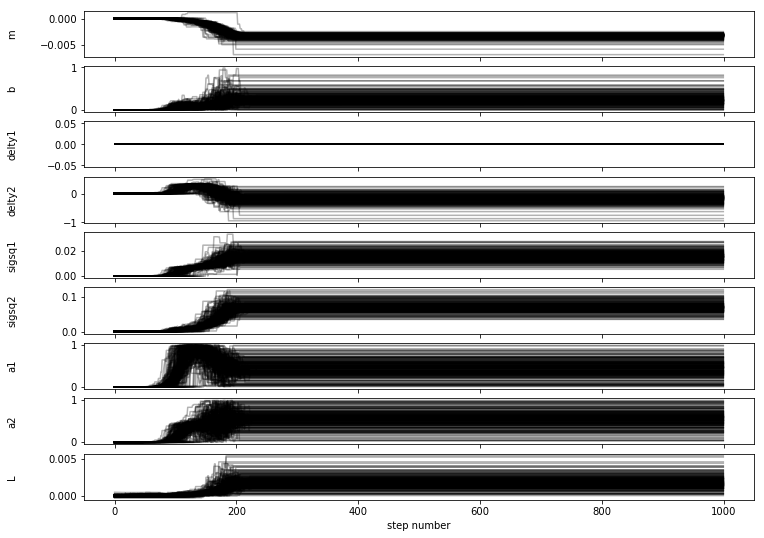

In [84]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(12, 9), sharex=True)
samples = sampler.chain
labels = ["m", "b", "delty1", "delty2", "sigsq1", "sigsq2", "a1", "a2", "L"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
    #(nwalkers, nsteps, dim)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_matrixeq22_L*.png")
plt.show()

In [85]:
flat_samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

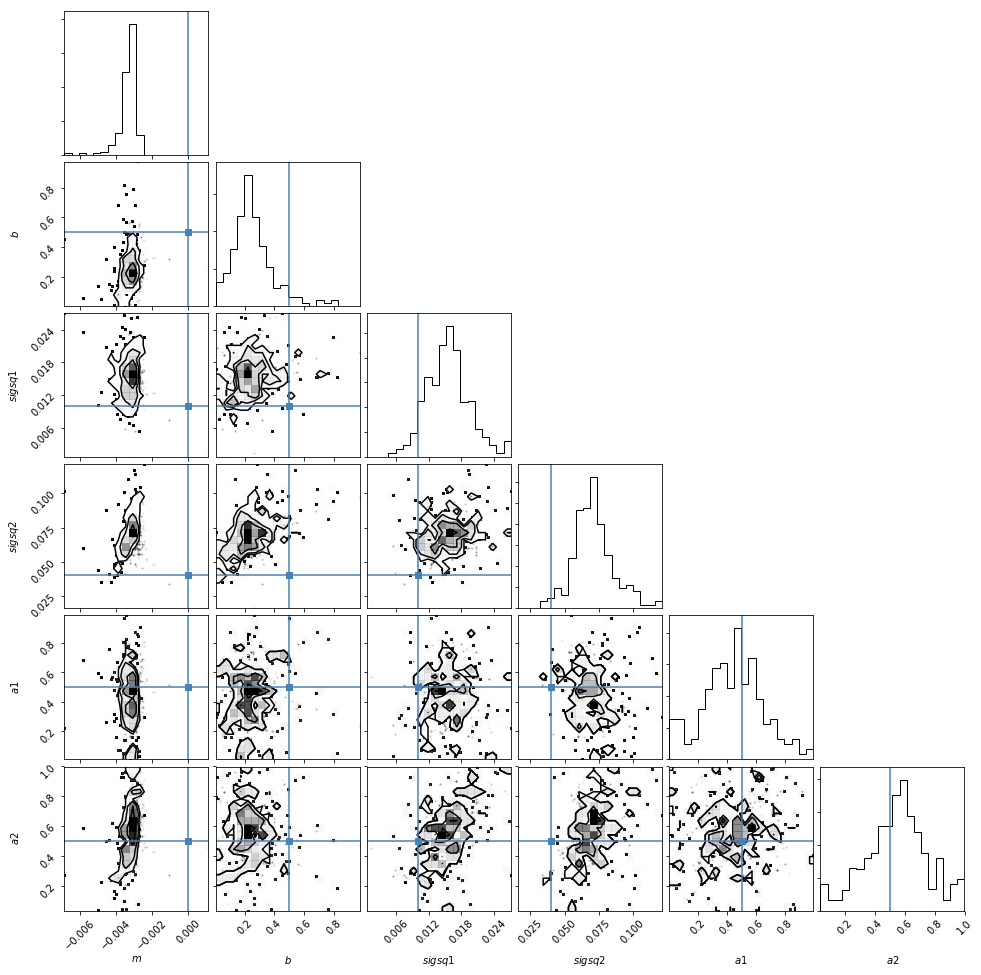

In [86]:
fig = corner.corner(flat_samples[:,[0,1,4,5,6,7]], labels=["$m$", "$b$", "$sigsq1$", "$sigsq2$", "$a1$", "$a2$"],
                      truths=[m_true, b_true, sigsq1_true, sigsq2_true, a1_true, a2_true])
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_corner_matrixeq22_L*.png")

In [87]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

-0.00322712715494 0.233275587851


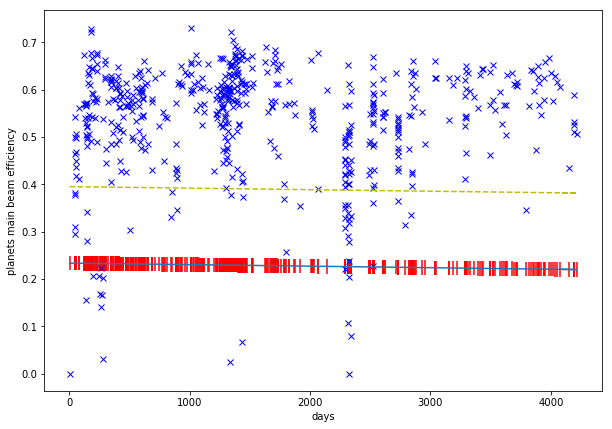

In [92]:
plt.figure(figsize=(10,7))
plt.plot(days, planets_etamb, 'bx')
m = results[0][1]
b = results[1][1]
print(m, b)
y = m*days/1000 + b
yerr = results[4][1]
bias = results[3][1]
plt.xlabel('days')
plt.ylabel('planets main beam efficiency')
plt.errorbar(days, y, yerr=yerr, ecolor='red')
plt.plot(days, y - bias, '--', color='y')
plt.show()